# Contexto

La industria ha ido evolucionando a lo largo del tiempo, desde el siglo XVIII, cuando surgieron las primeras máquinas que reemplazaron el trabajo manual de los trabajadores, hasta hoy, cuando siguen surgiendo nuevas tecnologías para facilitar, mejorar y optimizar el rendimiento en la fabricación y el mantenimiento de sistemas industriales (Universidad de Deusto, s. f.). 

Tradicionalmente, estos avances se han enfocado en procesos repetitivos o  de producción masiva, como la fabricación de tornillos, puertas o componentes mecánicos. Sin embargo, en las últimas décadas, la digitalización y la inteligencia artificial han abierto la puerta a aplicar los mismos principios de optimización en sectores más complejos y críticos, como la industria aeronáutica.

En este ámbito, los helicópteros son un caso especialmente interesante, pues su funcionamiento depende de sistemas muy sensibles, los cuales están sometidos a grandes esfuerzos mecánicos y donde cualquier fallo puede repercutir en consecuencias graves. Es por esto que es de vital importancia ser capaz de **detectar y predecir fallos en uno de los componentes más importantes del helicóptero, como son los motores** (corazón de helicóptero), permitiendo así mejorar la seguridad y la eficiencia en su construcción.


# Primeros pasos

Recomendamos crear un entorno virtual e instalar las dependencias necesarias para poder ejecutar el notebook. Para facilitar este paso, hemso creado un *requirements.txt*. Pasos a seguir:
> python3 -m venv nombre_entorno

> source nombre_entorno\bin\activate

> pip install -r requirements.txt

# Importación de Dependencias

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, recall_score, precision_score, cohen_kappa_score, balanced_accuracy_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras import layers
from imblearn.over_sampling import SMOTE
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.nn.utils.rnn import pack_padded_sequence, pad_sequence



from collections import Counter
import warnings
warnings.filterwarnings('ignore')


import importlib
import utils
import plots
import modelos.lstm_ventana_variable
importlib.reload(utils)
importlib.reload(plots)
importlib.reload(modelos.lstm_ventana_variable)




<module 'modelos.lstm_ventana_variable' from 'c:\\Users\\eneko.barbadillo\\Desktop\\Kode\\Industria\\analitica_turboshaft\\modelos\\lstm_ventana_variable.py'>

# Preparación de Datos

En esta primera fase cargaremos y analizaremos la información básica de los datos del dataset escogido de kaggle:
> https://www.kaggle.com/datasets/ziya07/helicopter-turboshaft-detection-dataset

## Carga y Exploración Inicial

In [2]:
file_name = "data/Helicopter_Turboshaft_Fault_Detection.csv"

try:
    #Cargar dataset
    df = pd.read_csv(file_name)
    print(f"Dataset cargado: {df.shape[0]} filas, {df.shape[1]} columnas")
except FileNotFoundError:
    print(f"No se ha encontrado el archivo {file_name} en la carpeta del proyecto")
except Exception as e:
    print(f"Error cargando el archivo: {e}")

Dataset cargado: 7012 filas, 11 columnas


In [3]:
#Informacion basica
print("\nINFORMACIÓN DEL DATASET:")
print(df.info())


INFORMACIÓN DEL DATASET:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7012 entries, 0 to 7011
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Timestamp             7012 non-null   object 
 1   Temp_Compressor       7012 non-null   float64
 2   Temp_Turbine          7012 non-null   float64
 3   Pressure_Compressor   7012 non-null   float64
 4   Vibration_Compressor  7012 non-null   float64
 5   Speed_Turbine         7012 non-null   float64
 6   Fuel_Flow             7012 non-null   float64
 7   Altitude              7012 non-null   float64
 8   Airspeed              7012 non-null   float64
 9   Ambient_Temp          7012 non-null   float64
 10  Fault_Label           7012 non-null   object 
dtypes: float64(9), object(2)
memory usage: 602.7+ KB
None


Podemos observar que los datos coinciden con la descripción proporcionada en Kaggle, ya que el conjunto cuenta con 11 columnas, una de las cuales corresponde a la etiqueta de error. En general, las columnas presentan los tipos de datos adecuados (numéricos y de texto), aunque la columna timestamp se encuentra actualmente como tipo string, por lo que será necesario convertirla a un formato de fecha y hora apropiado.

Para inspeccionar un poco más en profundidad, mostramos las primeras filas del conjunto de datos:

In [4]:
print("\nPRIMERAS FILAS:")
df.head()


PRIMERAS FILAS:


,Timestamp,Temp_Compressor,Temp_Turbine,Pressure_Compressor,Vibration_Compressor,Speed_Turbine,Fuel_Flow,Altitude,Airspeed,Ambient_Temp,Fault_Label
0,2024-03-01 00:00:00,0.516699,-0.482741,1.218923,0.439431,1.109674,0.259894,-0.457097,0.935177,0.520473,Normal
1,2024-03-01 01:00:00,-0.137372,-1.071038,-0.581229,0.165394,-0.344521,0.381376,1.416960,-0.804455,-0.461119,Normal
2,2024-03-01 02:00:00,0.672213,-0.867799,0.268908,1.551952,1.156725,0.647181,0.053060,-1.435661,-1.606553,Normal
3,2024-03-01 03:00:00,1.573874,-1.351055,0.142967,0.176228,0.047683,-1.703167,-1.739264,-0.980834,0.247414,Normal
4,2024-03-01 04:00:00,-0.236144,-0.949079,-1.116520,0.251032,0.122548,-0.376294,0.681555,0.341163,-1.328883,Turbine Blade Damage


Obtenemos las estadísticas descriptivas básicas para tener una visión general de la distribución de los datos, incluyendo medidas como la media, mediana, desviación estándar, valores mínimos y máximos, y cuartiles.

In [5]:
print("\nESTADÍSTICAS DESCRIPTIVAS:")
df.describe()


ESTADÍSTICAS DESCRIPTIVAS:


,Temp_Compressor,Temp_Turbine,Pressure_Compressor,Vibration_Compressor,Speed_Turbine,Fuel_Flow,Altitude,Airspeed,Ambient_Temp
count,7.012000e+03,7.012000e+03,7.012000e+03,7.012000e+03,7.012000e+03,7.012000e+03,7.012000e+03,7.012000e+03,7.012000e+03
mean,-1.045750e-15,-2.294165e-15,-4.245827e-16,1.504786e-16,6.220796e-15,-1.381161e-15,-3.850631e-17,-9.525245e-17,2.148247e-16
std,1.000071e+00,1.000071e+00,1.000071e+00,1.000071e+00,1.000071e+00,1.000071e+00,1.000071e+00,1.000071e+00,1.000071e+00
min,-2.772926e+00,-2.731452e+00,-2.779824e+00,-2.818930e+00,-2.797912e+00,-2.810185e+00,-1.742798e+00,-1.738476e+00,-2.803083e+00
25%,-6.834192e-01,-6.938367e-01,-6.953875e-01,-7.161923e-01,-6.923787e-01,-6.965294e-01,-8.454536e-01,-8.659915e-01,-7.014270e-01
50%,1.456606e-03,-6.255666e-03,2.105707e-03,1.382664e-02,-6.137782e-03,7.190528e-03,-2.740623e-03,1.511656e-02,2.227411e-03
75%,6.888450e-01,6.816986e-01,6.988208e-01,6.946732e-01,6.977878e-01,7.026591e-01,8.707817e-01,8.738380e-01,6.980463e-01
max,2.779058e+00,2.768032e+00,2.785446e+00,2.790486e+00,2.795210e+00,2.798471e+00,1.726135e+00,1.732903e+00,2.808385e+00


Podemos observar que todos los atributos numéricos han sido **previamente escalados**, ya que la media de cada columna es cercana a cero y la desviación estándar es aproximadamente 1. Esto indica que se ha aplicado algún tipo de normalización o estandarización.

Este escalado facilitará la aplicación de modelos de aprendizaje automático, ya que las variables están en una escala comparable y no predominará ninguna por su magnitud.

## Limpieza

### Análisis de valores nulos

Analizar la presencia de valores nulos en los datos es fundamental, ya que su presencia puede afectar la calidad de los datos, distorsionar estadísticas y provocar errores en los modelos de predicción. Detectarlos permite decidir cómo tratarlos y asegurar que los resultados sean confiables y reproducibles.

In [6]:
missing_data = df.isnull().sum()
print(missing_data)

Timestamp               0
Temp_Compressor         0
Temp_Turbine            0
Pressure_Compressor     0
Vibration_Compressor    0
Speed_Turbine           0
Fuel_Flow               0
Altitude                0
Airspeed                0
Ambient_Temp            0
Fault_Label             0
dtype: int64


En este caso, no se detectaron valores nulos en el dataset, por lo que se omite la etapa de manejo de NAs e interpolación, lo que facilita el análisis y la preparación de los datos para los modelos de predicción.

### Conversión a formato temporal

Como se ha visto antes, la columna *Timestamp* es actualmente una cadena de texto. Para facilitar la gestión y el análisis de fechas y horas, procederemos a convertir estos datos a un formato de fecha y hora adecuado.

In [7]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
        
#Informacion temporal general
print(f"Primer registro: {df['Timestamp'].min()}")
print(f"Ultimo registro: {df['Timestamp'].max()}")
print(f"Duracion total: {df['Timestamp'].max() - df['Timestamp'].min()}")
        
#Verificar frecuencia: en este caso, deberia mantenerse constante a aproximadamente 1h
diferencias_tiempo = df['Timestamp'].diff().dropna()
frecuencia_esperada = pd.Timedelta(hours=1) #Frecuencia esperada = 1h
consistencia_frecuencia = (diferencias_tiempo == frecuencia_esperada).mean()
        
print(f"Consistencia de frecuencia (1h): {consistencia_frecuencia:.2%}")

Primer registro: 2024-03-01 00:00:00
Ultimo registro: 2024-12-31 23:00:00
Duracion total: 305 days 23:00:00
Consistencia de frecuencia (1h): 95.46%


Tras convertir la columna Timestamp a un formato de fecha y hora, se observa que el primer registro corresponde al 1 de marzo de 2024 a las 00:00 y el último al 31 de diciembre de 2024 a las 23:00, abarcando una duración total de 305 días y 23 horas, tal y como se indicaba en kaggle.

Al analizar la consistencia de la frecuencia temporal, se verifica que aproximadamente el 95,5 % de los registros mantienen el intervalo esperado de 1 hora, indicando que la serie temporal es en su mayoría regular, aunque existen algunos huecos o inconsistencias menores.

# Análisis Exploratorio de los Datos

En esta fase del análisis exploratorio, seguimos un enfoque **de lo general a lo específico**.

## Detección de Outliers

Primero examinamos la distribución de los valores de cada sensor y evaluamos la cantidad de outliers detectados.

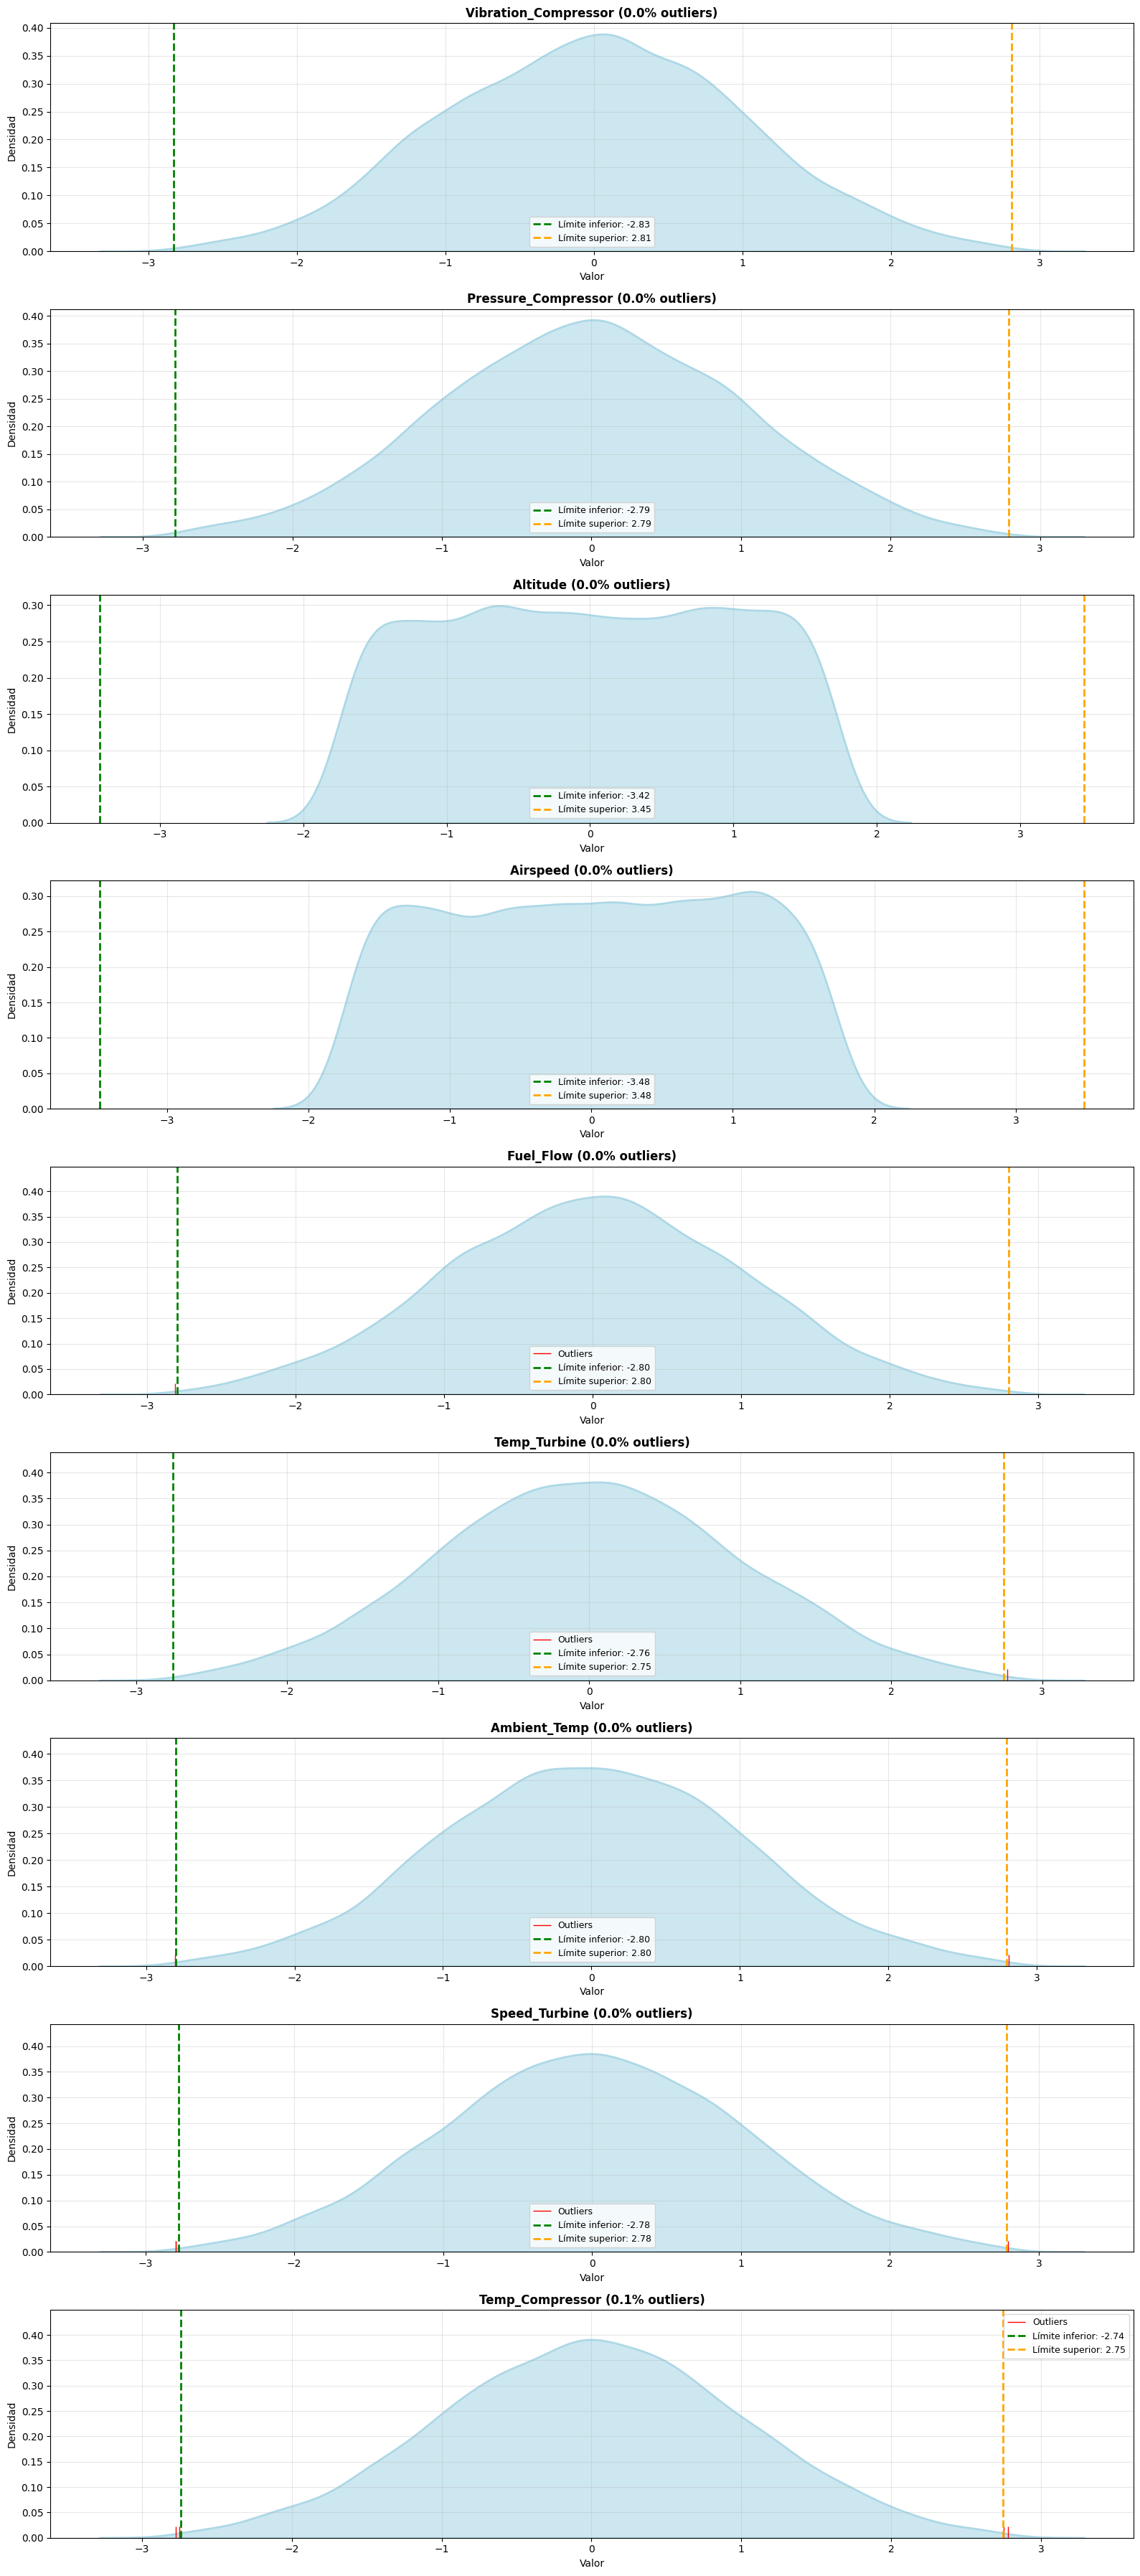

In [8]:
from utils import generar_df_estadisticas_outliers
from plots import plot_distribuciones_outliers


#Obtenemos la información necesaria para el plot
resultados_df = generar_df_estadisticas_outliers(df)

#Graficar las distribuciones
fig = plot_distribuciones_outliers(df, resultados_df)
plt.tight_layout() #Para una mejor visualizacion (que no se solapen los plots)
plt.show(fig)


Observamos que los datos presentan una media cercana a cero, lo cual confirma que estaban previamente normalizados, tal como se esperaba. Es por ello que obtaremos por conservar los outliers detectados como parte de la dataset.

## Correlación entre variables

A continuación, investigaremos si existe alguna relación entre los sensores disponibles (columnas numéricas). Esto nos permitirá **identificar posibles dependencias** entre ellos y, en caso de encontrar sensores altamente correlacionados, considerar la posibilidad de eliminar aquellos redundantes. De esta manera, podremos **simplificar el modelo sin perder información relevante y mejorar la eficiencia del análisis**.

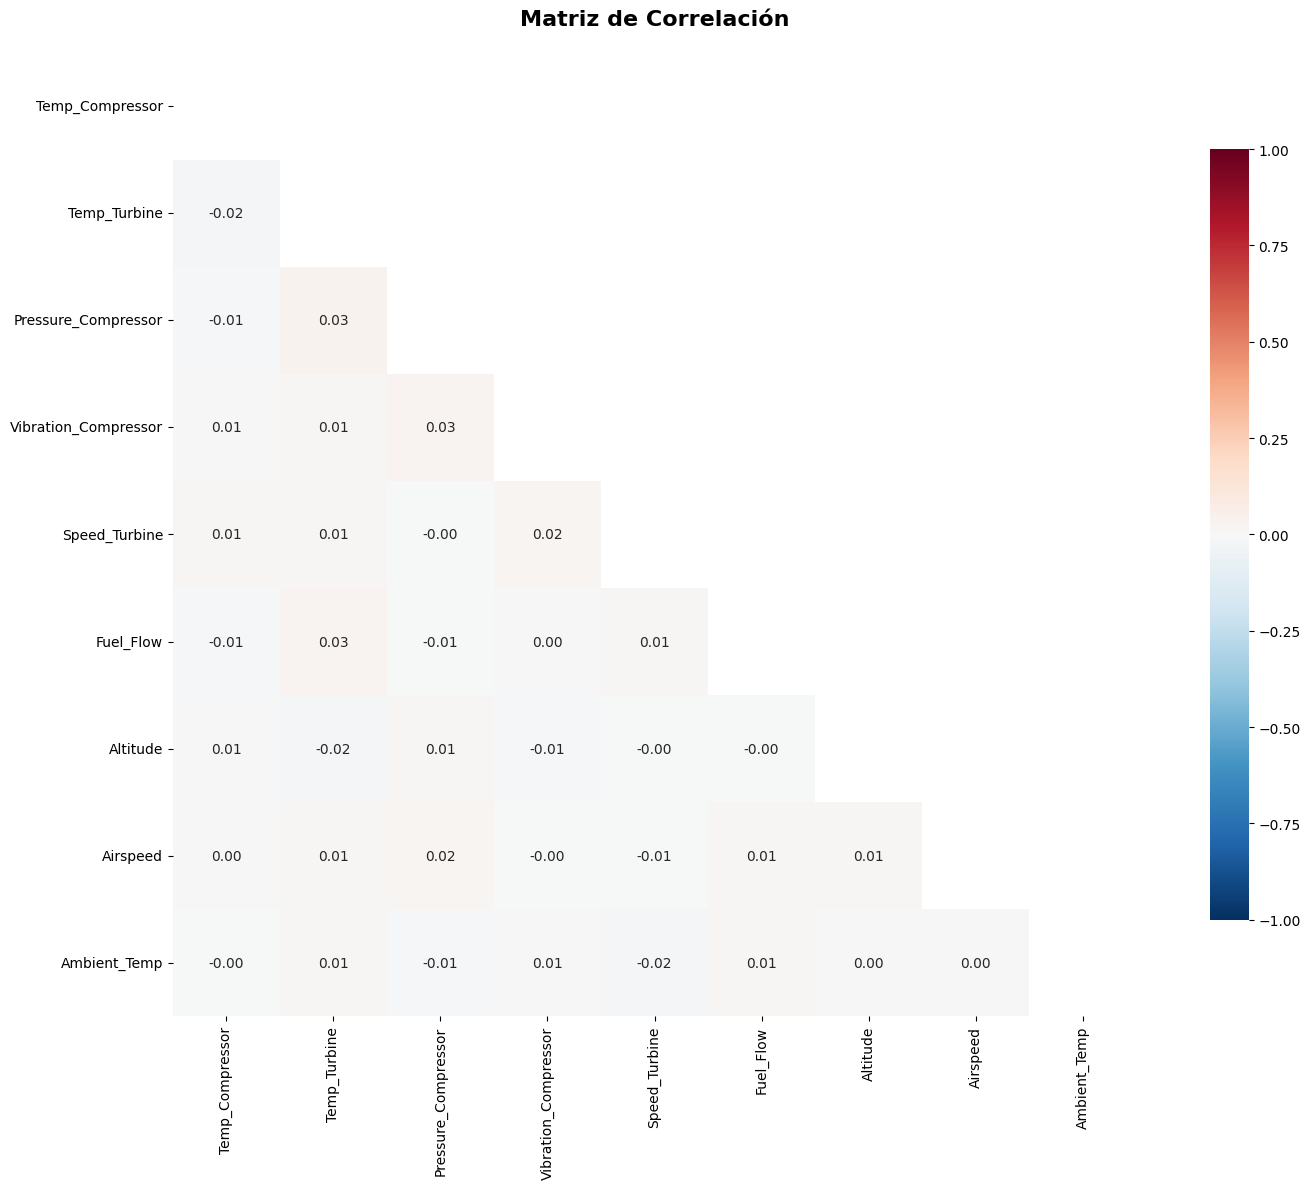

In [9]:
from utils import calculo_matriz_correlacion
from plots import plot_correlacion_heatmap

#Calcular la matriz de correlación
numeric_cols = ['Temp_Compressor','Temp_Turbine','Pressure_Compressor','Vibration_Compressor',
                'Speed_Turbine','Fuel_Flow','Altitude','Airspeed','Ambient_Temp']

corr_matrix = calculo_matriz_correlacion(df, numeric_cols)

#Graficar el heatmap
fig = plot_correlacion_heatmap(corr_matrix)
plt.tight_layout()
plt.show() 

Como se observa, los sensores son independientes entre sí, ya que la correlación entre ellos ronda cero. Esto indica que **ningún sensor es redundante**, lo que implica que cada uno aporta información única al análisis.

Si lo trasladamos al dominio real, esto tiene sentido ya que cada sensor captura fenómenos independientes, sin relaciones lineales simples entre ellos. Además, es probable que los fallos afecten a múltiples sensores de manera compleja, reflejando la interacción real de los sistemas del motor.

## Análisis de distribución de fallos

Con el objetivo de profundizar en el entendimiento de los datos, analizaremos la distribución de los fallos, que es la variable más importante en nuestro caso ya que es el objetivo a predecir.

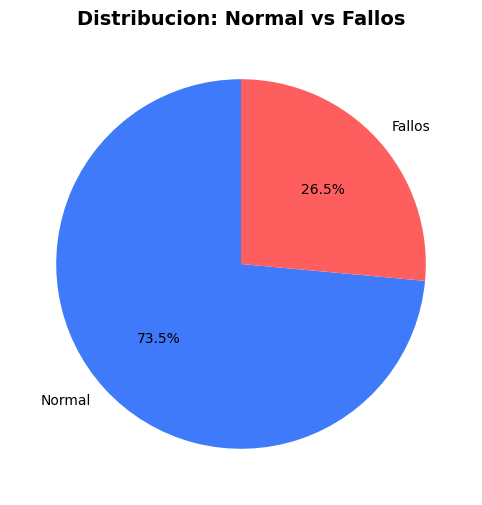

In [10]:
from plots import pie_chart

df["fallo"] = np.where(df["Fault_Label"] == "Normal", "Normal", "Fallos")
fig = pie_chart(df, "fallo", paleta = ["#3f7afa", "#ff5e5e"], titulo="Distribucion: Normal vs Fallos")
plt.show(fig)

Como se puede observar, existe un **gran desbalance entre los datos** sin fallo y los datos con fallo. Esto puede afectar negativamente al modelo, ya que podría tender a predecir mayoritariamente la clase más frecuente, ignorando los casos de fallo y reduciendo su capacidad de detectar eventos importantes. De hecho, si el modelo predijera todas las observaciones como normales, alcanzaría un accuracy del 73,54 %, lo que refleja que la métrica por sí sola no sería suficiente para evaluar su rendimiento.

Para comprender mejor el contexto, vamos a desglosar los datos según los distintos tipos de fallo, lo que nos permitirá identificar patrones específicos y la distribución de cada categoría dentro del dataset.

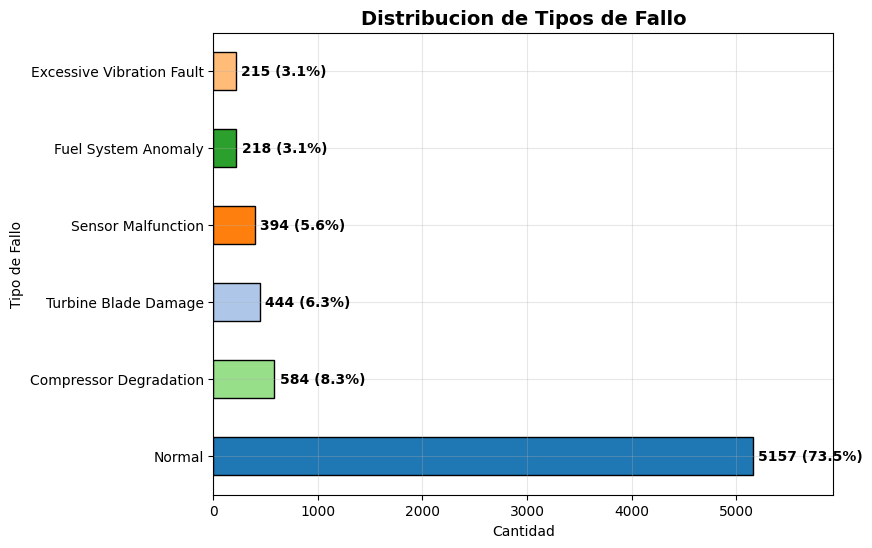

In [11]:
from utils import definicion_paleta
from plots import bar_chart

paleta = definicion_paleta(df, "Fault_Label")
fig = bar_chart(df, "Fault_Label", paleta, "Distribucion de Tipos de Fallo", "Cantidad", "Tipo de Fallo")
plt.show(fig)

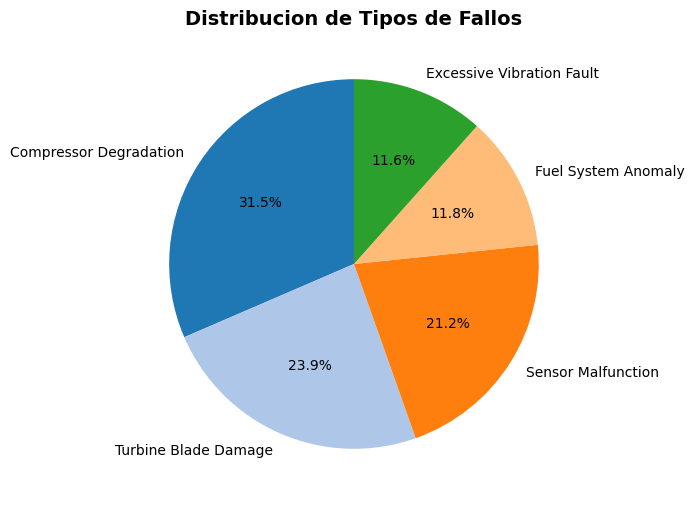

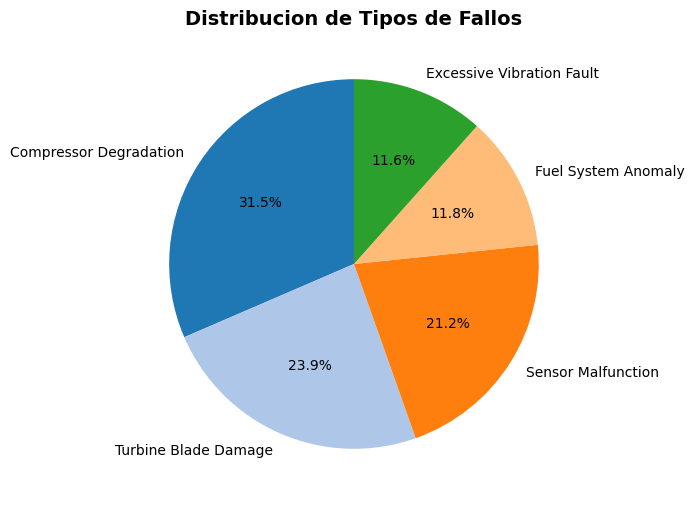

In [12]:
from plots import pie_chart

df_fallos = df[df['Fault_Label'] != 'Normal']
pie_chart(df_fallos, "Fault_Label", titulo="Distribucion de Tipos de Fallos")

Podemos observar que la distribución entre los distintos tipos de fallo es más variada, indicando que algunos errores ocurren con mayor frecuencia que otros y que existe diversidad en la aparición de los fallos dentro del dataset.

## Análisis de sensores

A continuación, intentaremos verificar si existe alguna relación entre los sensores y fallos específicos. A modo de ejemplo, podríamos observar que un fallo en la temperatura del compresor podría estar asociado con un aumento en la velocidad de la turbina, lo que nos permitiría identificar patrones de comportamiento entre sensores y tipos de fallo.

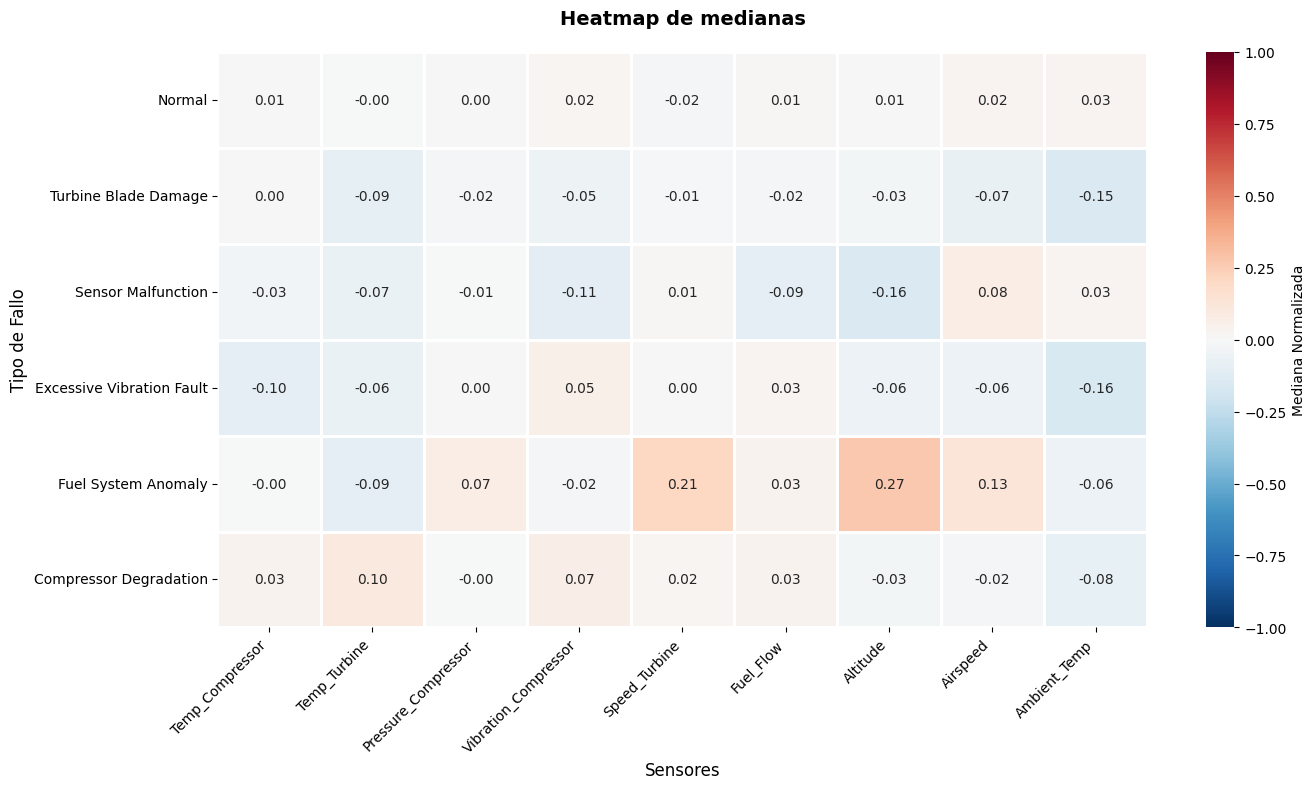

In [13]:
from utils import calcular_medianas_por_fallo
from plots import plot_heatmap_medianas

fallos = ['Normal', 'Turbine Blade Damage', 'Sensor Malfunction', 'Excessive Vibration Fault', 'Fuel System Anomaly', 'Compressor Degradation']

sensores_principales = ['Temp_Compressor', 'Temp_Turbine', 'Pressure_Compressor', 
                        'Vibration_Compressor', 'Speed_Turbine', 'Fuel_Flow', 
                        'Altitude', 'Airspeed', 'Ambient_Temp']

median_matrix = calcular_medianas_por_fallo(df, fallos, sensores_principales)
plot_heatmap_medianas(median_matrix)
plt.tight_layout()
plt.show()



In [14]:
from utils import analisis_patrones_por_fallo

analisis_patrones_por_fallo(fallos, median_matrix)

Análisis de patrones por fallo:
--------------------------------

Normal:
  Sensor más CARACTERÍSTICO: Ambient_Temp (0.03)

Turbine Blade Damage:
  Sensor más CARACTERÍSTICO: Ambient_Temp (-0.15)

Sensor Malfunction:
  Sensor más CARACTERÍSTICO: Altitude (-0.16)

Excessive Vibration Fault:
  Sensor más CARACTERÍSTICO: Ambient_Temp (-0.16)

Fuel System Anomaly:
  Sensor más CARACTERÍSTICO: Altitude (0.27)

Compressor Degradation:
  Sensor más CARACTERÍSTICO: Temp_Turbine (0.10)


La decisión de utilizar la mediana en lugar de la media se basa en la necesidad de evitar que lecturas puntuales erróneas de los sensores distorsionen los resultados. La media puede verse fácilmente afectada por outliers, mientras que la mediana proporciona un valor más robusto frente a estos casos. Aunque en nuestro dataset los datos están limpios, esta práctica asegura que el análisis siga siendo fiable si se aplicara a conjuntos de datos con posibles errores o mediciones atípicas.

La mayoría de los fallos tienen como sensor más característico uno que mide valores ambientales, no del motor:
- *Ambient_Temp*: 3 de 6 fallos
- *Altitude*:  2 de 6 fallos

Que estos sensores aparezcan como predictores principales no tiene sentido físico, ya que un fallo de motor no debería depender de la hora del día o de la altitud. A modo de ejemplo, si quisiéramos predecir si una persona está enferma, deberíamos medir fiebre o tos, no si es de día o de noche. Aunque una degradación de algún componente podría afectar ligeramente la altitud, no debería ser un sensor principal para detectar fallos.

Esto sugiere dos posibles causas:
1. El dataset puede contener errores al haber recogido los datos.
2. Los fallos podrían ocurrir en condiciones ambientales específicas, aunque esto parece poco probable, ya que la matriz de correlación entre sensores no muestra relaciones significativas.

Ahora vamos a verificar si esto es cierto o si se trata de un posible error del dataset.

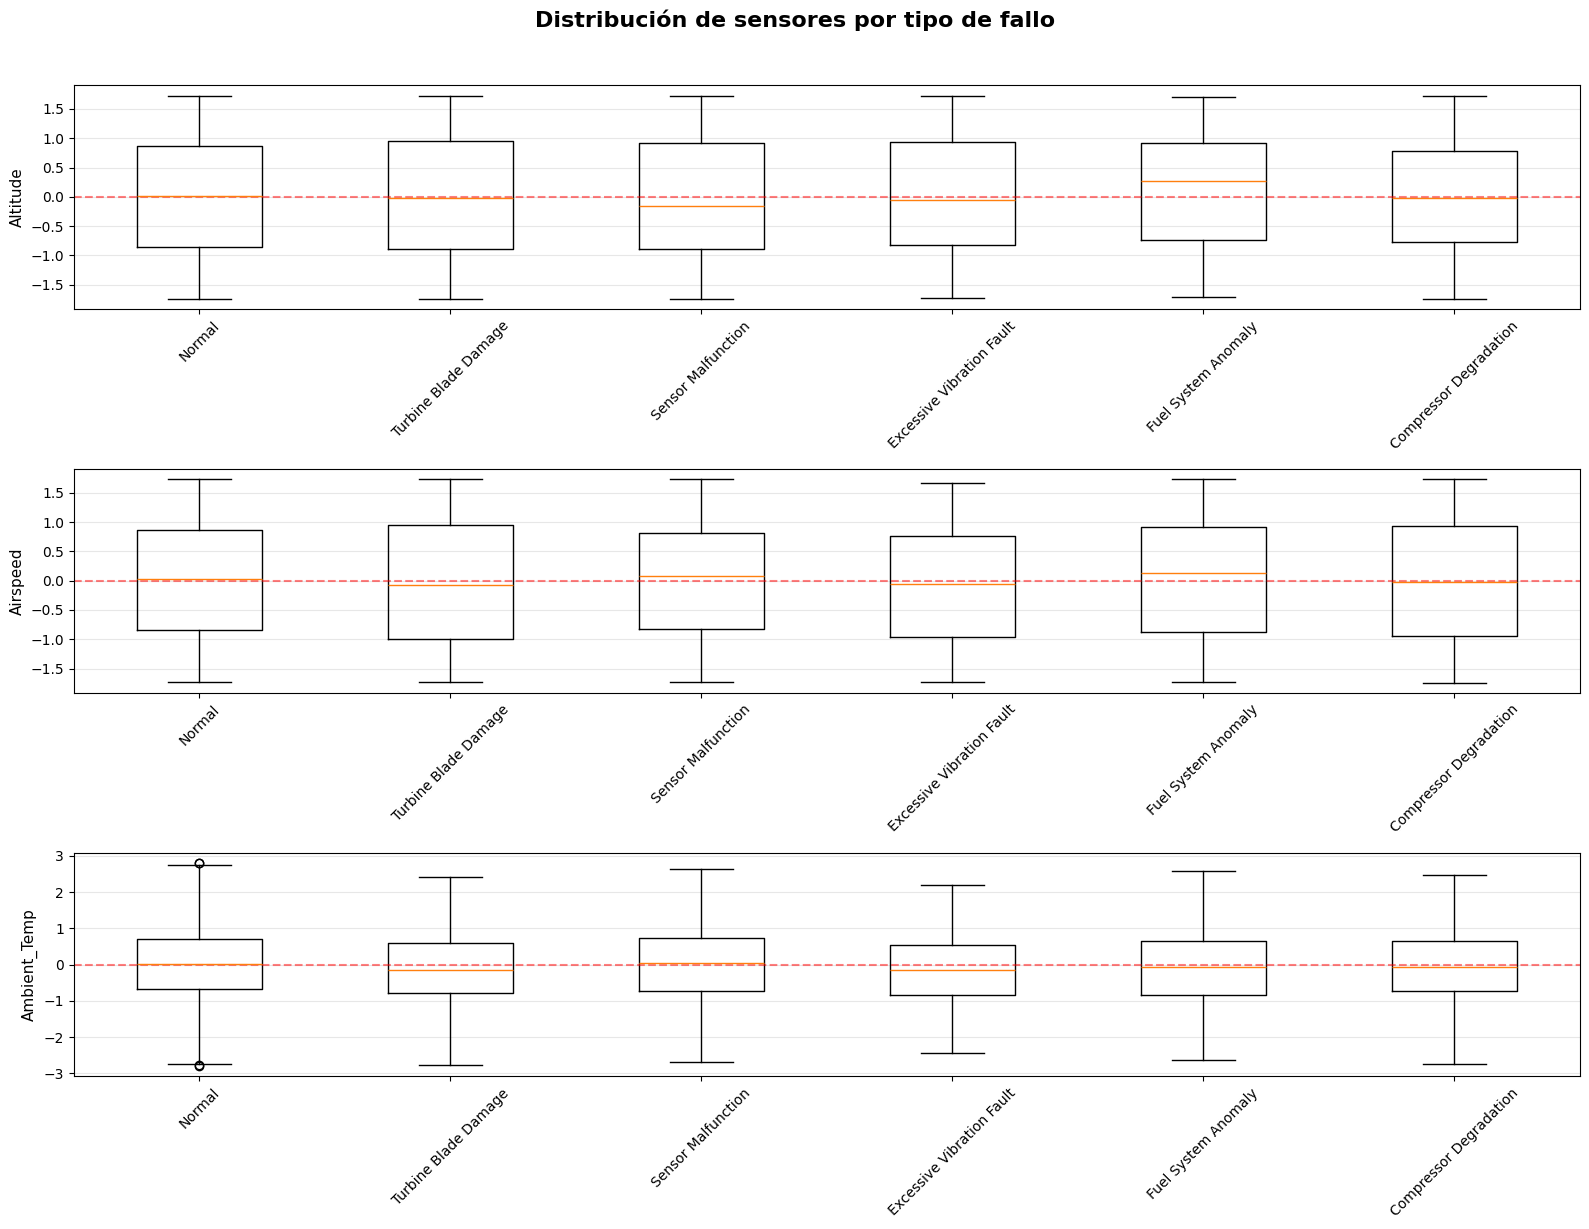

In [15]:
from plots import boxplots_por_sensor

sensores_ambientales = ["Altitude", "Airspeed", "Ambient_Temp"]

fallos = ['Normal', 'Turbine Blade Damage', 'Sensor Malfunction', 'Excessive Vibration Fault', 'Fuel System Anomaly', 'Compressor Degradation']

fig = boxplots_por_sensor(df, sensores_ambientales, fallos)
plt.tight_layout()
plt.show(fig)

Como se ve en los boxplots de los sensores ambientales, las medianas están cerca de cero. Esto indica que los fallos no dependen de variables ambientales, por lo que los datos están correctos en este aspecto.

El motivo de que algunos sensores aparezcan como destacados es simplemente que en un heatmap normalizado siempre habrá un valor más alto y uno más bajo. Esto no significa que ese sensor cause el fallo, solo que tiene la mayor diferencia relativa respecto a los demás.

Para comprender mejor el dominio y extraer *insights*, consideramos conveniente realizar un análisis exhaustivo de las relaciones y cambios entre los sensores cuando ocurre un fallo. Por ello, vamos a analizar estos patrones con mayor profundidad.

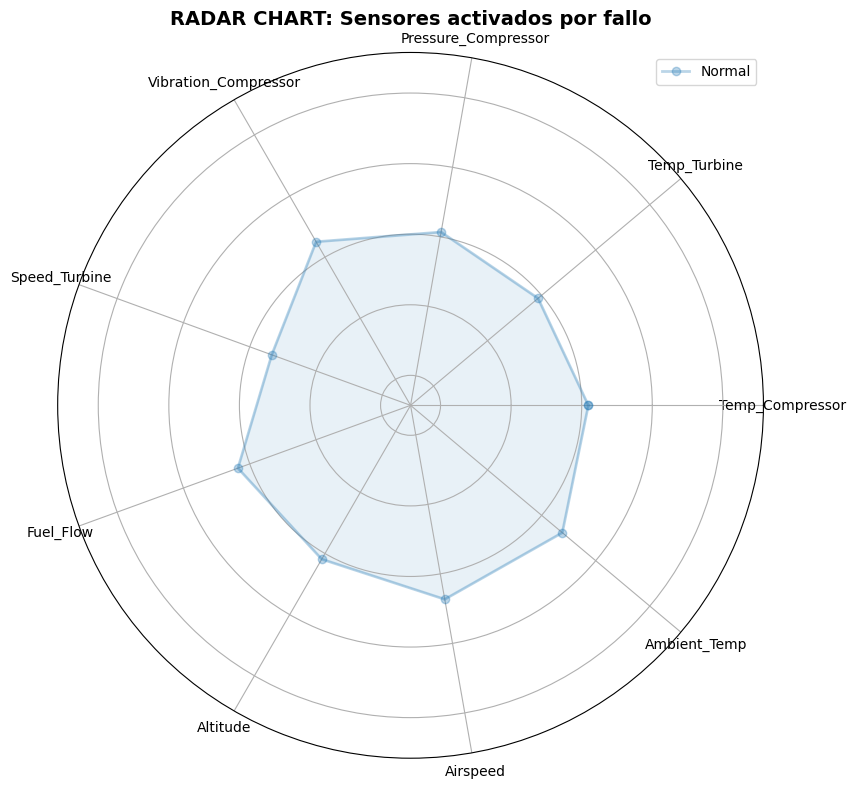

In [16]:
from plots import radar_plot

fallos = ['Normal']
sensores_principales = ['Temp_Compressor', 'Temp_Turbine', 'Pressure_Compressor', 
                        'Vibration_Compressor', 'Speed_Turbine', 'Fuel_Flow', 
                        'Altitude', 'Airspeed', 'Ambient_Temp']

fig = radar_plot(
    fallos=fallos,
    median_matrix=median_matrix,
    sensores=sensores_principales,
)

plt.tight_layout()
plt.show(fig)

Recordemos que todos los valores están **normalizados**, lo que permite compararlos bajo una misma escala. No obstante, para facilitar la visualización, el gráfico utiliza un factor de **amplitud**, ya que de lo contrario las diferencias eran mínimas y no se apreciaban los cambios.

En el caso **Normal** (base de comparación): los sensores forman un patrón relativamente regular (no perfecto, porque en la vida real siempre hay cierta variabilidad). Este patrón sirve como referencia,cualquier fallo que se desvíe significativamente de él puede considerarse una anomalía.

Teniendo ya definida la estructura de los sensores en una situación normal, ahora vamos a analizar qué sensores se activan ante cada tipo de fallo. No estudiaremos todos los casos, pero sí algunos ejemplos representativos que nos permitan entender de forma general cómo se comportan los sensores cuando ocurre un fallo.

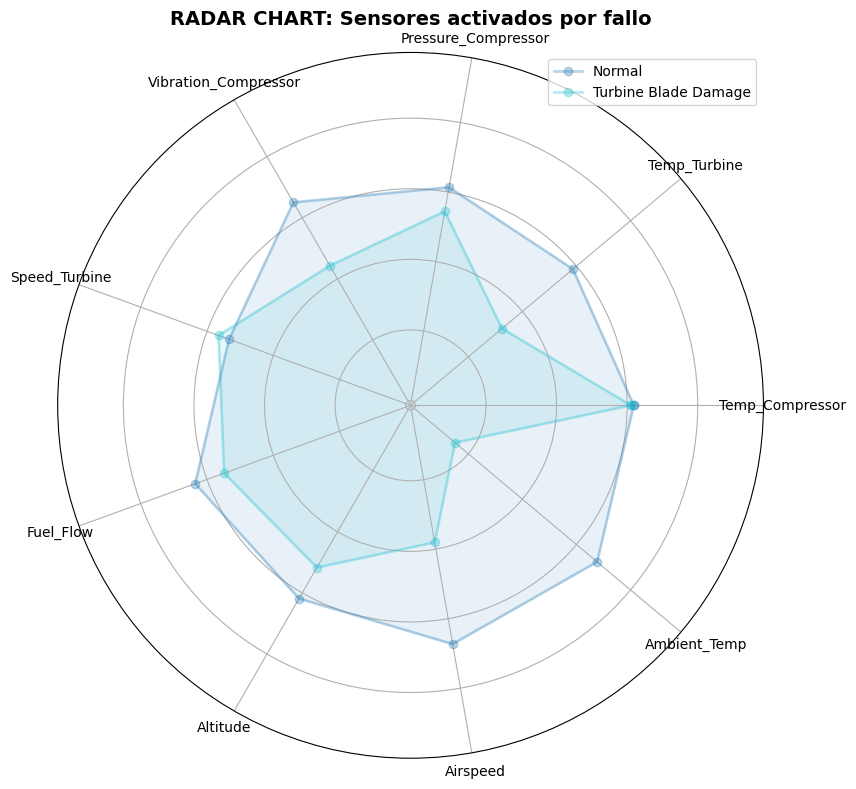

In [17]:
fallos = ['Normal', 'Turbine Blade Damage']

fig = radar_plot(
    fallos=fallos,
    median_matrix=median_matrix,
    sensores=sensores_principales
)

plt.tight_layout()
plt.show(fig)


<!-- - **Turbine Blade Damage**: Los sensores que más destacan son *Temp_Turbine*, *Ambient_Temp*, *Airspeed* y *Vibration_Compressor*. Esto se explica físicamente ya que si la turbina está dañada, no extrae energía eficientemente, los gases pasan sin interactuar y la turbina se “apaga”, es decir no hace esfuerzo y por tanto, la temperatura baja. Además, el sistema reduce carga para protegerse, disminuyendo la vibración. -->

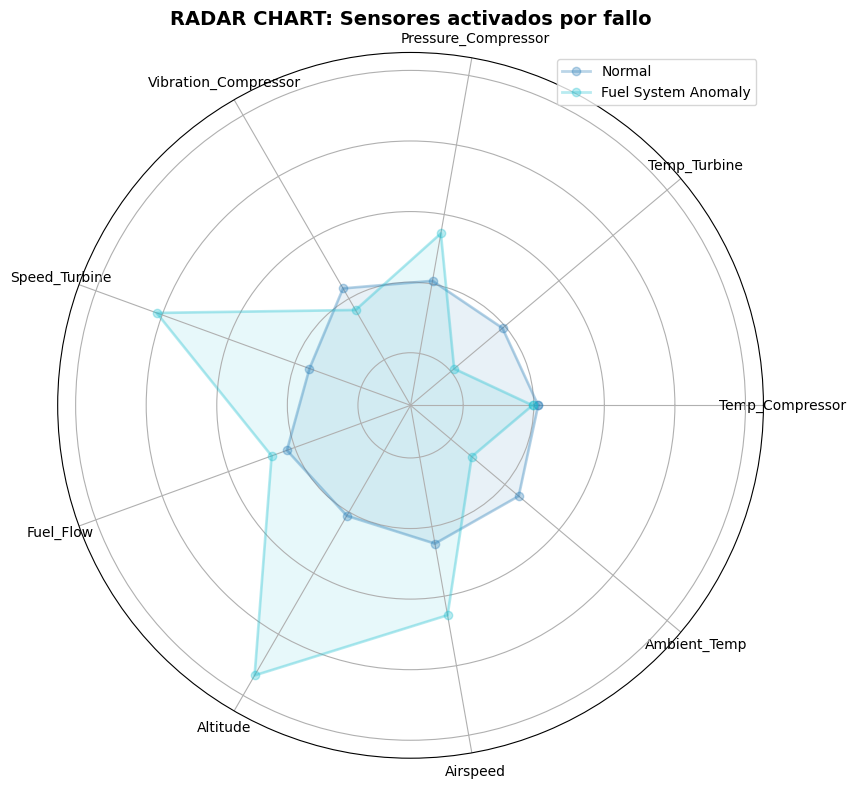

In [18]:
fallos = ['Normal', 'Fuel System Anomaly']

fig = radar_plot(
    fallos=fallos,
    median_matrix=median_matrix,
    sensores=sensores_principales,
    factor=2
)

plt.tight_layout()
plt.show(fig)


- **Fuel System Anomaly**: En este caso parece que se inyecte más combustible de lo normal. Es por ello que el motor aumenta sus RPM (Speed_Turbine) para quemar el exceso. Este exceso de combustible provoca que la cámara se enfríe (Temp_Turbine), lo cual es un aspecto clave para interpretar los sensores. Como consecuencia, se genera más potencia temporalmente, lo que hace que el avión acelere (Airspeed) y ascienda (Altitude).

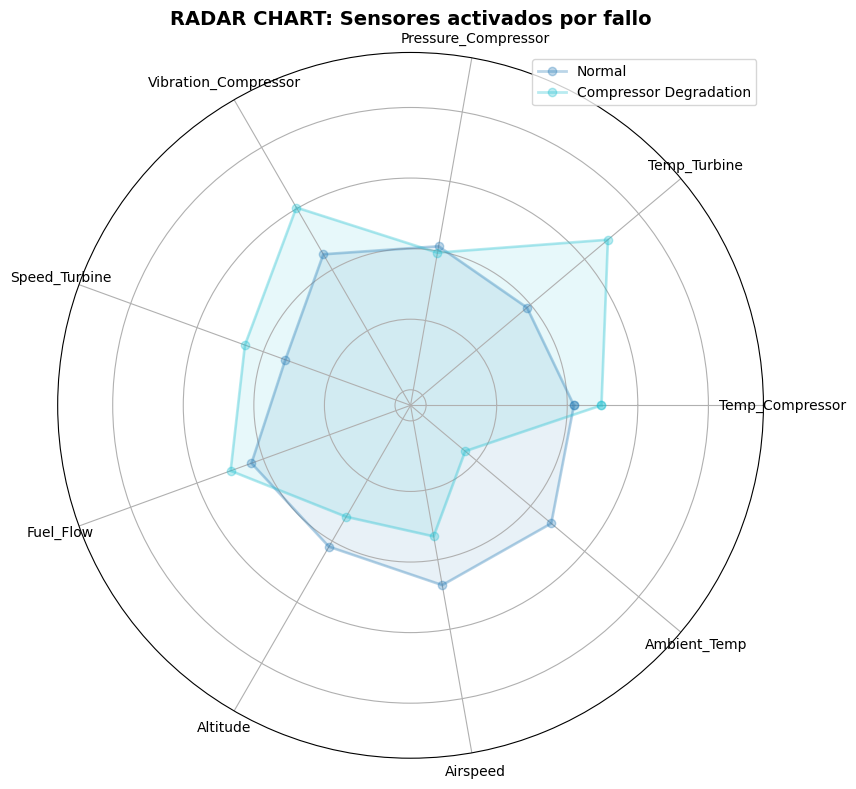

In [19]:
fallos = ['Normal', 'Compressor Degradation']

fig = radar_plot(
    fallos=fallos,
    median_matrix=median_matrix,
    sensores=sensores_principales,
)

plt.tight_layout()
plt.show(fig)

- **Compressor Degradation**: El sensor vibration_Compressor aumenta por desbalance mecánico, Temp_Turbine aumenta debido al aire mal comprimido y gases más calientes, y Airspeed disminuye reflejando la pérdida de eficiencia del motor, ya que el aumento de temperatura no se traduce en potencia útil.

Hemos analizado algunos ejemplos de lo que ocurre cada vez que se detecta un cambio en los sensores. Este problema resulta complejo, ya que un fallo no se refleja en un único sensor, sino en varios simultáneamente. Además, muchos cambios consideran variaciones en temperatura ambiente, airspeed o altitud, pero en realidad el modelo no debería basarse en estos valores para determinar un fallo, ya que no son causales directos del error.

Por ello, vamos a intentar **identificar patrones en los sensores a lo largo del tiempo**. Para ello, utilizaremos un gráfico que muestre la evolución de los sensores durante las cinco horas previas a un fallo específico, con el objetivo de verificar si se repiten ciertos patrones antes de que ocurra el error.

Podríamos probar siguiendo los cambios de sensores que hemos visto en el radar char:

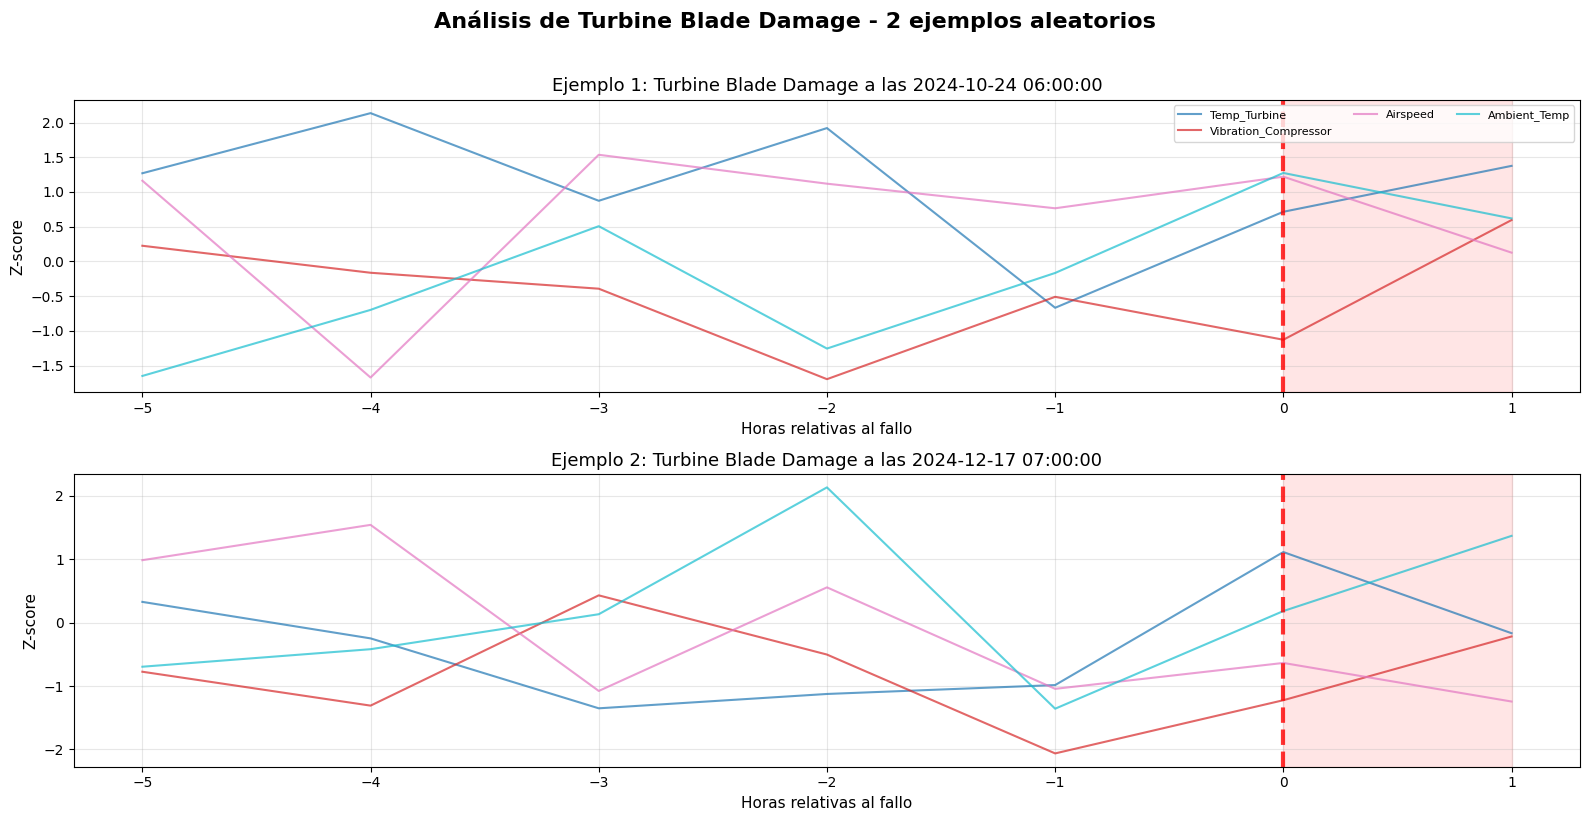

In [20]:
from plots import timeline_por_tipo_fallo

sensores_principales = ['Temp_Turbine',
                        'Vibration_Compressor', 'Airspeed', 'Ambient_Temp']

fig, ejemplos_turbine = timeline_por_tipo_fallo(df, sensores=sensores_principales, fallo='Turbine Blade Damage', n_ejemplos=2)

plt.tight_layout()
plt.show(fig)

O incluso todos los sensores:

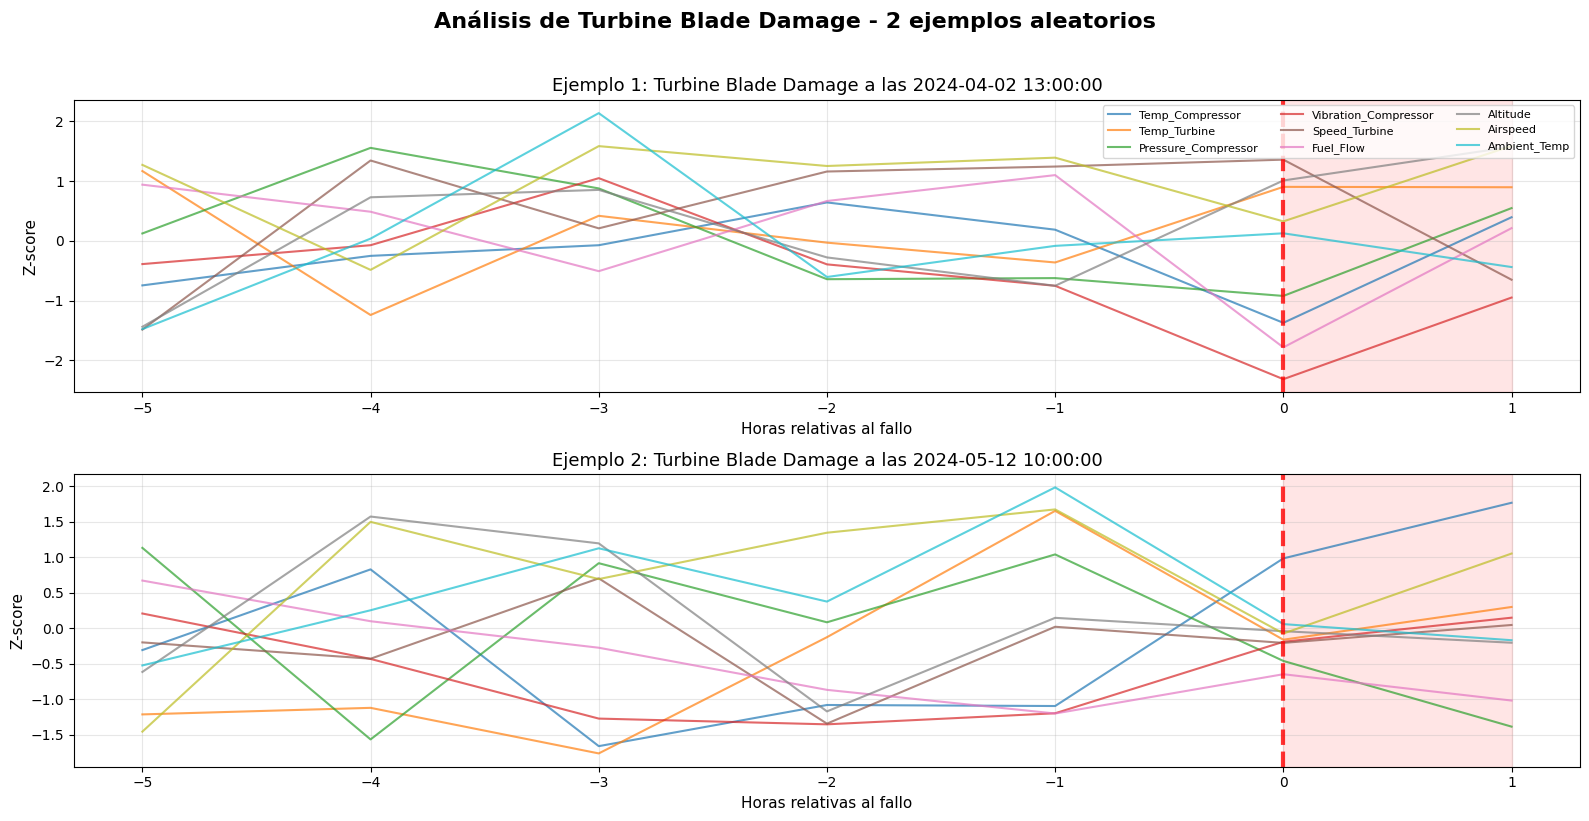

In [21]:
sensores_principales = ['Temp_Compressor', 'Temp_Turbine', 'Pressure_Compressor', 
                        'Vibration_Compressor', 'Speed_Turbine', 'Fuel_Flow', 
                        'Altitude', 'Airspeed', 'Ambient_Temp']

fig, ejemplos_turbine = timeline_por_tipo_fallo(df, sensores=sensores_principales, fallo='Turbine Blade Damage', n_ejemplos=2)

plt.tight_layout()
plt.show(fig)

Consideramos conveniente medir los fallos de manera cuantitativa. Por ello, en esa misma ventana de horas, podemos calcular el cambio promedio de los sensores, lo que nos permitirá evaluar numéricamente la magnitud de los cambios antes de un fallo.

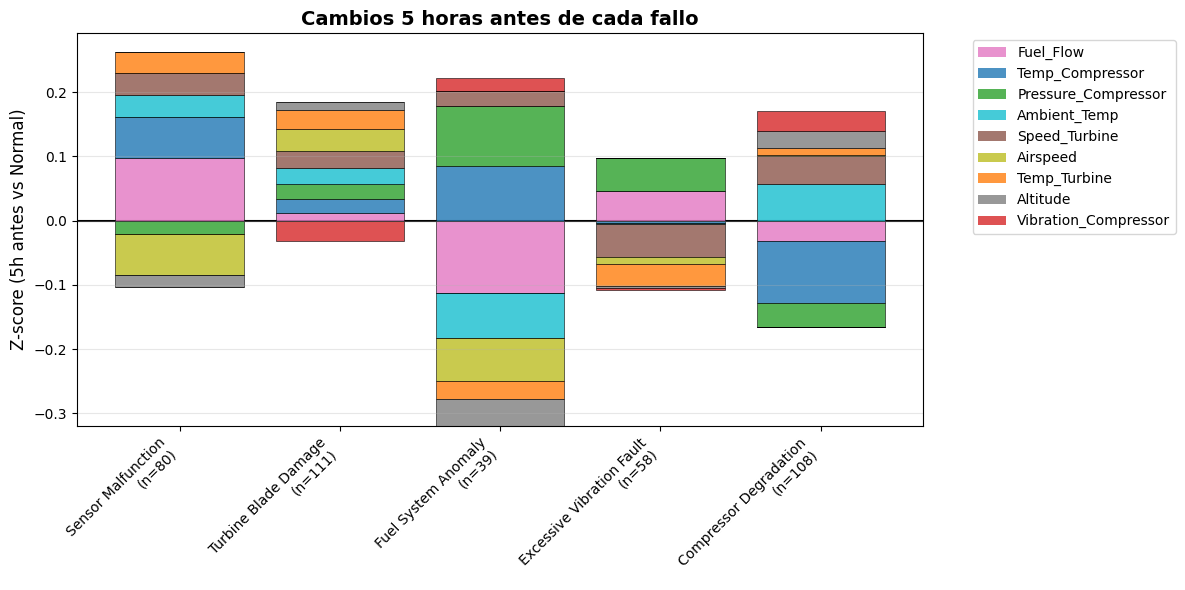

In [22]:
from plots import plot_cambio_5h

fig = plot_cambio_5h(df, sensores_principales)
plt.tight_layout()
plt.show(fig)

Podemos observar que la distribución de los cambios en los sensores **varía según el tipo de fallo**. No obstante, continúa predominando un patrón de diferencias mínimas, lo que puede dificultar la detección de fallos por parte de los modelos.

## Síntesis de observaciones

A modo de resumen, hemos identificado varios aspectos clave a tener en cuenta para el desarrollo de nuestros modelos:

- **Datos normalizados**: Los datos ya vienen normalizados en z-score, lo que permite compararlos bajo una misma escala y facilita el análisis sin necesidad de un preprocesamiento adicional.

- **Correlación entre sensores**: No existe correlación significativa entre los sensores, lo que indica que cada uno mide un fenómeno distinto y no hay redundancia entre ellos. Esto refuerza la idea de que todos aportan información única.

- **Distribución de fallos**: El dataset presenta un fuerte desbalance, con un 73,5 % de casos normales frente a un 26,5 % con fallos. Será necesario considerar modelos que manejen bien este tipo de desbalances o aplicar técnicas de resampling (oversampling, undersampling o SMOTE).

- **Sensores predominantes**: Los sensores con mayor peso aparente son los que miden condiciones ambientales, aunque esto se debe a que *uno tenía que serlo*, ya que las diferencias entre sensores son mínimas. Para evitar sesgos en el modelo, podría ser conveniente probar entrenamientos sin estos sensores y evaluar si mejora la precisión.

- **Fallos sin consistencia temporal**: No se observan patrones claros en las horas previas a un fallo específico, lo que complica la detección temprana y sugiere que las relaciones entre sensores y fallos podrían ser no lineales o de naturaleza más compleja.

# Modelos de predicción

Esta sección aborda el desarrollo de modelos de aprendizaje automático para la **deteción de fallos a partir de datos de sensores** analizados anteriormente. Tras el análisis exploratorio previo, se identificó
- Que los datos se encuentran normalizados.
- Que no presentan correlaciones entre sensores.
- Que existe un desbalance entre casos normales y fallos.

Teniendo todo esto en cuenta, se tratará de desarrollar un pipeline de clasificación que permita **comparar diferentes algoritmos** desde modelos sencillos y faciles de interpretar, hasya modelos más complejos y robustos para hacer frente a relaciones no lineales.

Además, se incorporarán técnicas de manejo de desbalance de clases, garantizando que los modelos preseten suficiente atención a fallos minoritarios y se evaluará mediante métricas el desempeño de los modelos.

## Preparación de datos

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

Antes de trabajar con modelos, es necesario preparar los datos para que estos puedan entenderlos. Para ello utilizaremos el *labelEnconder* de *scikit-learn* que permite convertir etiquetas categoricas en números enteros. En este caso nos será útil para transformar nuestra variable objetivo ('*Fault_Label*) en una categoría en valores numéricos para que los modelos de machine learning puedan procesarla.

### Ingeniería de características

In [ ]:
#creamos "medias móviles" (el promedio de los últimos 5 valores del sensor) para suavizar el ruido de los sensores
#esto ayuda al modelo a ver la tendencia general en lugar de picos sueltos.

#identificamos las columnas de sensores (excluyendo la label y timestamp)
cols_sensores = df.select_dtypes(include=[np.number]).columns.tolist()
if 'Fault_Label' in cols_sensores: cols_sensores.remove('Fault_Label')

#creamos nuevas variables con una ventana de tiempo
#(el promedio de los últimos 5 datos)
ventana = 5

for col in cols_sensores:
    #Tendencia
    df[f'{col}_mean_{ventana}'] = df[col].rolling(window=ventana).mean()
    
    #std
    df[f'{col}_std_{ventana}'] = df[col].rolling(window=ventana).std()

#para la limpieza (al crear ventanas, las primeras filas quedan vacías osea que las rellenamos).
df = df.fillna(method='bfill').fillna(method='ffill')

print(f"Dimensiones nuevas del dataset: {df.shape}")
# ----------------------------------------------

Ingeniería de características completada.
Dimensiones nuevas del dataset: (7012, 33)


In [56]:
from utils import preprocesar_datos

X, y, le = preprocesar_datos(df)

### Selección de características

In [57]:
print(f"Características originales ({X.shape[1]}): {X.columns.tolist()}")

#Usamos Random Forest para ver qué sensores importan de verdad
sel_model = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
sel_model.fit(X, y)

#Obtenemos la importancia y seleccionamos las mejores
#cogemos los 7 mejores
importancias = pd.Series(sel_model.feature_importances_, index=X.columns)
mejores_features = importancias.nlargest(7).index.tolist()

#tambiém podríamos elegir las que superen un umbral
#mejores_features = importancias[importancias > 0.05].index.tolist()

print(f"Características seleccionadas ({len(mejores_features)}): {mejores_features}")

X = X[mejores_features]

Características originales (29): ['Temp_Compressor', 'Temp_Turbine', 'Pressure_Compressor', 'Vibration_Compressor', 'Speed_Turbine', 'Fuel_Flow', 'Altitude', 'Airspeed', 'Ambient_Temp', 'Temp_Compressor_mean_5', 'Temp_Compressor_std_5', 'Temp_Turbine_mean_5', 'Temp_Turbine_std_5', 'Pressure_Compressor_mean_5', 'Pressure_Compressor_std_5', 'Vibration_Compressor_mean_5', 'Vibration_Compressor_std_5', 'Speed_Turbine_mean_5', 'Speed_Turbine_std_5', 'Fuel_Flow_mean_5', 'Fuel_Flow_std_5', 'Altitude_mean_5', 'Altitude_std_5', 'Airspeed_mean_5', 'Airspeed_std_5', 'Ambient_Temp_mean_5', 'Ambient_Temp_std_5', 'Fault_Label_Encoded_mean_5', 'Fault_Label_Encoded_std_5']
Características seleccionadas (7): ['Fault_Label_Encoded_std_5', 'Fault_Label_Encoded_mean_5', 'Temp_Turbine', 'Altitude', 'Pressure_Compressor_mean_5', 'Speed_Turbine_std_5', 'Speed_Turbine']


Ahora se tiene que dividir los datos en conjuntos de entrenamiento (training) y prueba (test) para poder evaluar correctamente el rendimiento del modelo y evitar el sobreajuste.

Para garantizar que la proporción de clases (normal/fallo) se mantenga en ambos conjuntos, se utilizará el parámetro *stratify*. Esto es especialmente importante en datasets desbalanceados, ya que evita que alguna clase quede subrepresentada en entrenamiento o prueba, lo que podría afectar negativamente al rendimiento del modelo.

In [58]:
from utils import split_data

X_train, X_test, y_train, y_test = split_data(X, y)

print(f"Distribución de clases en entrenamiento: {np.bincount(y_train)}")
print(f"Distribución de clases en prueba: {np.bincount(y_test)}")


Distribución de clases en entrenamiento: [ 409  150  152 3610  276  311]
Distribución de clases en prueba: [ 175   65   66 1547  118  133]


## Modelos

A continuación, se van a entrenar y evaluar diferentes modelos de clasificación para comparar su rendimiento en la detección de fallos.

### Modelos básicos

Se utilizará el mismo conjunto de entrenamiento y prueba previamente definido, así como la función *evaluar_modelo*, para asegurar que la evaluación sea consistente entre todos los modelos.

#### Random Forest

En este caso, Random Forest es un buen modelo porque combina múltiples árboles de decisión para **capturar relaciones complejas entre los sensores**. Es robusto frente a sobreajuste si se limita la profundidad de los árboles y puede manejar de manera eficiente el desbalance de clases utilizando el parámetro ***class_weight='balanced***'. Además, es capaz de detectar interacciones no lineales entre las variables, algo frecuente en datos de fallos mecánicos.

Resultados del Modelo
---------------------
Accuracy: 0.702
Balanced Accuracy: 0.214
F1 Global: 0.639
Kappa: 0.084
Muestras en test: 2104

Métricas por Clase:


,Clase,Precision,Recall,F1
0,Compressor Degradation,0.245,0.149,0.185
1,Excessive Vibration Fault,0.238,0.077,0.116
2,Fuel System Anomaly,0.111,0.030,0.048
3,Normal,0.748,0.924,0.827
4,Sensor Malfunction,0.227,0.042,0.071
5,Turbine Blade Damage,0.320,0.060,0.101


Distribución de clases en el conjunto de test:
  Compressor Degradation: 175 muestras (8.32%)
  Excessive Vibration Fault: 65 muestras (3.09%)
  Fuel System Anomaly: 66 muestras (3.14%)
  Normal: 1547 muestras (73.53%)
  Sensor Malfunction: 118 muestras (5.61%)
  Turbine Blade Damage: 133 muestras (6.32%)

Matriz de Confusión:


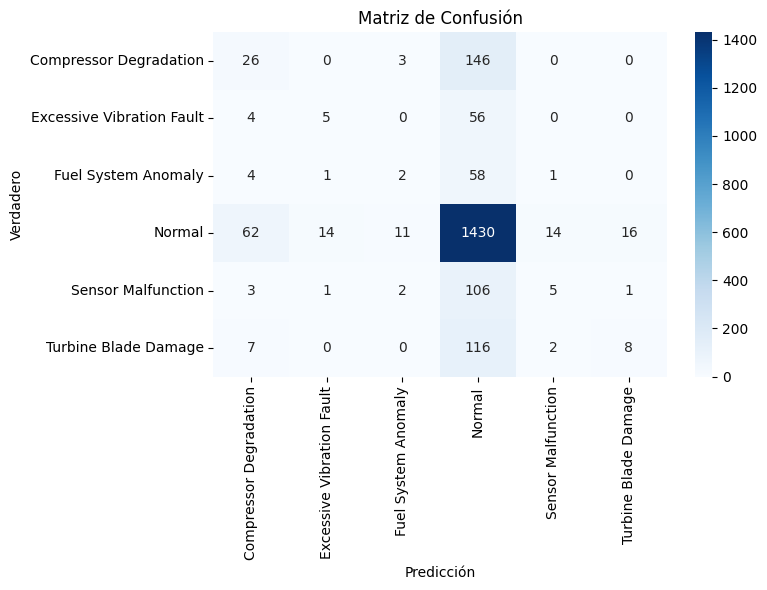

In [59]:
from utils import evaluar_modelo_scikit
from utils import mostrar_resultados_notebook, mostrar_resultados_notebook_variable

rf_model = RandomForestClassifier(n_estimators=10, random_state=111, class_weight='balanced')
resultados_rf = evaluar_modelo_scikit(rf_model, X_train, X_test, y_train, y_test, "Random Forest", le)

mostrar_resultados_notebook(resultados_rf, le)

#### Gradient Boosting

Gradient Boosting es adecuado porque construye árboles de manera secuencial, corrigiendo los errores de los anteriores. Esto le permite capturar patrones más complejos que un único árbol y mejorar la **precisión en problemas multiclas**. También puede ajustarse para manejar desequilibrio en las clases y es **menos propenso a predecir únicamente la clase mayoritaria** en datasets desbalanceados.

Resultados del Modelo
---------------------
Accuracy: 0.617
Balanced Accuracy: 0.333
F1 Global: 0.630
Kappa: 0.207
Muestras en test: 2104

Métricas por Clase:


,Clase,Precision,Recall,F1
0,Compressor Degradation,0.269,0.423,0.329
1,Excessive Vibration Fault,0.180,0.169,0.175
2,Fuel System Anomaly,0.109,0.091,0.099
3,Normal,0.798,0.732,0.764
4,Sensor Malfunction,0.228,0.246,0.237
5,Turbine Blade Damage,0.271,0.338,0.301


Distribución de clases en el conjunto de test:
  Compressor Degradation: 175 muestras (8.32%)
  Excessive Vibration Fault: 65 muestras (3.09%)
  Fuel System Anomaly: 66 muestras (3.14%)
  Normal: 1547 muestras (73.53%)
  Sensor Malfunction: 118 muestras (5.61%)
  Turbine Blade Damage: 133 muestras (6.32%)

Matriz de Confusión:


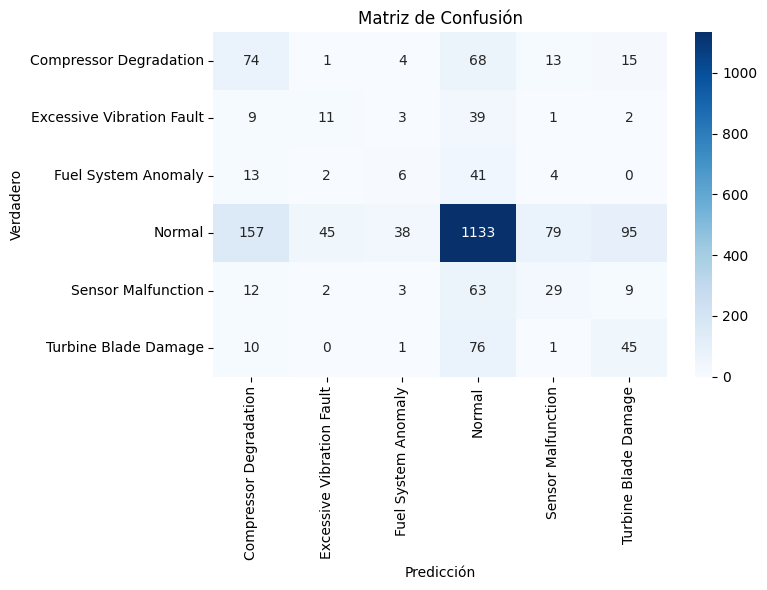

In [60]:
gb_model = HistGradientBoostingClassifier(max_iter=100, random_state=111, class_weight='balanced')
resultados_gb = evaluar_modelo_scikit(gb_model, X_train, X_test, y_train, y_test, "HistGradientBoosting", le)
mostrar_resultados_notebook(resultados_gb, le)

#### XGBoost

XGBoost es una versión optimizada de Gradient Boosting, diseñada para ser más rápida y eficiente. Permite un control fino sobre regularización, profundidad de los árboles y balance de clases, lo que lo hace especialmente útil cuando algunas **fallas son minoritarias y difíciles de detectar**. Su eficiencia computacional permite entrenar modelos robustos sin comprometer el rendimiento.

Resultados del Modelo
---------------------
Accuracy: 0.716
Balanced Accuracy: 0.237
F1 Global: 0.659
Kappa: 0.142
Muestras en test: 2104

Métricas por Clase:


,Clase,Precision,Recall,F1
0,Compressor Degradation,0.300,0.154,0.204
1,Excessive Vibration Fault,0.316,0.092,0.143
2,Fuel System Anomaly,0.222,0.061,0.095
3,Normal,0.763,0.935,0.840
4,Sensor Malfunction,0.200,0.059,0.092
5,Turbine Blade Damage,0.356,0.120,0.180


Distribución de clases en el conjunto de test:
  Compressor Degradation: 175 muestras (8.32%)
  Excessive Vibration Fault: 65 muestras (3.09%)
  Fuel System Anomaly: 66 muestras (3.14%)
  Normal: 1547 muestras (73.53%)
  Sensor Malfunction: 118 muestras (5.61%)
  Turbine Blade Damage: 133 muestras (6.32%)

Matriz de Confusión:


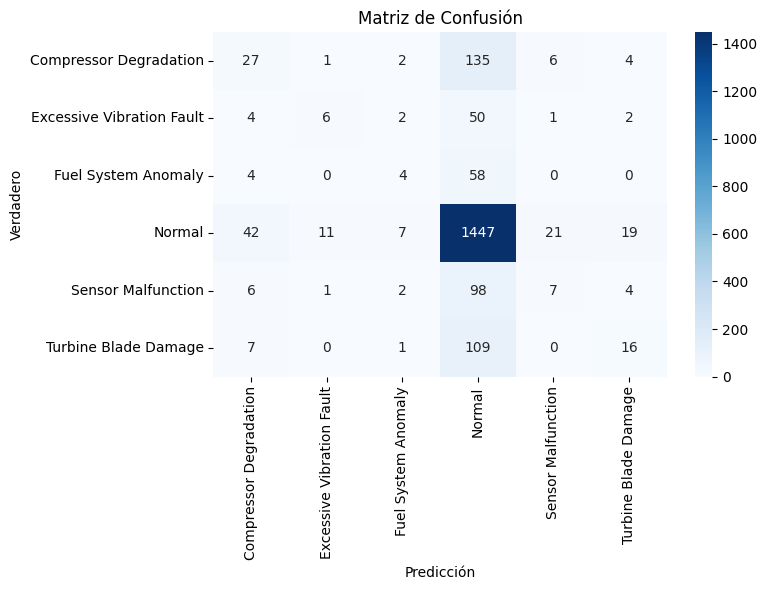

In [61]:
ratio = np.bincount(y_train)[0] / np.bincount(y_train)[1]
xgb_model = XGBClassifier(n_estimators=100, random_state=111, use_label_encoder=False, eval_metric='mlogloss', scale_pos_weight=ratio)
resultados_xgb = evaluar_modelo_scikit(xgb_model, X_train, X_test, y_train, y_test, "XGBoost", le)
mostrar_resultados_notebook(resultados_xgb, le)

#### Support Vector Machine (SVM)

SVM es útil en este problema porque busca un **margen óptimo entre clases, lo que ayuda a separar fallos minoritarios de la clase mayoritaria**. Usando un kernel no lineal (como RBF), puede capturar relaciones complejas entre los sensores que no se ven linealmente.

Resultados del Modelo
---------------------
Accuracy: 0.146
Balanced Accuracy: 0.173
F1 Global: 0.192
Kappa: 0.006
Muestras en test: 2104

Métricas por Clase:


,Clase,Precision,Recall,F1
0,Compressor Degradation,0.081,0.177,0.111
1,Excessive Vibration Fault,0.040,0.231,0.068
2,Fuel System Anomaly,0.035,0.152,0.057
3,Normal,0.776,0.134,0.229
4,Sensor Malfunction,0.052,0.195,0.082
5,Turbine Blade Damage,0.058,0.150,0.084


Distribución de clases en el conjunto de test:
  Compressor Degradation: 175 muestras (8.32%)
  Excessive Vibration Fault: 65 muestras (3.09%)
  Fuel System Anomaly: 66 muestras (3.14%)
  Normal: 1547 muestras (73.53%)
  Sensor Malfunction: 118 muestras (5.61%)
  Turbine Blade Damage: 133 muestras (6.32%)

Matriz de Confusión:


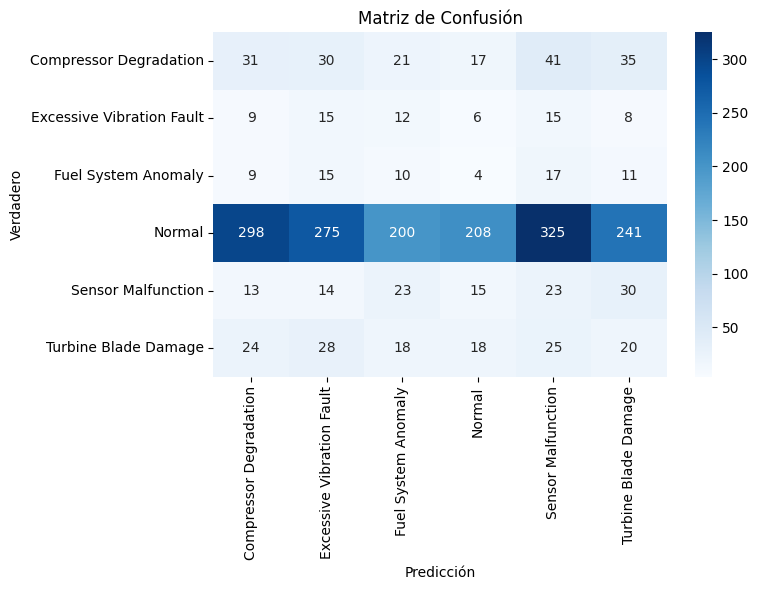

In [29]:
svm_model = SVC(kernel='rbf', probability=True, random_state=111, class_weight='balanced')
resultados_svm = evaluar_modelo_scikit(svm_model, X_train, X_test, y_train, y_test, "SVM", le)
mostrar_resultados_notebook(resultados_svm, le)

#### Métricas

Las diferentes métricas utilizadas son porque queríamos **evaluar el modelo desde varios ángulos**, no solo con la precisión global. Dado que nuestro dataset está muy desbalanceado, con la clase “Normal” predominando, la accuracy por sí sola no refleja si el modelo detecta correctamente los fallos minoritarios. Por eso también usamos Balanced Accuracy y Cohen’s Kappa, que corrigen el efecto del desbalance, y métricas por clase como precision, recall y F1, para analizar específicamente cómo se desempeña el modelo en cada tipo de fallo. De esta manera podemos identificar si el modelo detecta bien los fallos críticos o si necesita ajustes como class weights u oversampling.

#### Conclusiones de modelos básicos

Como se observa en los resultados, los modelos tienden a aprender principalmente a **predecir la clase mayoritaria** (*'Fault_Label = Normal'*), lo que se refleja en un alto accuracy global y un F1-score elevado para esta clase. Sin embargo, **fallan casi por completo al intentar detectar las clases minoritarias, que representan los diferentes tipos de fallos**. Esto indica que, aunque la predicción de la clase mayoritaria es buena, el modelo no es suficiente para el objetivo principal del problema, que es identificar correctamente los fallos raros, precisamente las clases más relevantes para la detección temprana y la prevención de incidentes.

### Modelo básico de Deep Learning

A continuación se tratará de abordar el problema utilizando un modelo de red neuronal básico. Para ello, se utilizará una multilayer perceptron (MLP) que consiste en tres capas densas con activación ReLU, permitiendo **capturar relaciones no lineales entre sensores**.

La capa de salida utilizará *softmax* por la naturaleza del problema (clasificación multiclas) además de ser optimizado con *categorical_crossentropy* función de pérdida adecuada para este tipo de tareas.

In [30]:
from modelos.mlp import MLP
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'

input_dim = X_train.shape[1] #Numero de características (columnas de X_train)
output_dim = len(np.unique(y_train)) #Numero de clases, objetivo a predecir

model = MLP(input_dim=input_dim, output_dim=output_dim)



In [31]:
from utils import entrenar_evaluar_pytorch

resultados = entrenar_evaluar_pytorch(
    model=model,
    X_train=X_train.values, 
    X_test=X_test.values,
    y_train=y_train.values,
    y_test=y_test.values,
    le=le,
    epochs=50,
    batch_size=128,
    lr=0.001,
    device=device
    )

Como se observa, no se ha logrado un cambio significativo respecto a los modelos anteriores. Sin embargo, el uso de una red neuronal permite **capturar relaciones no lineales entre los sensores**, algo que los modelos tradicionales de scikit-learn no explotan completamente. Esto abre la posibilidad de mejorar el rendimiento aplicando técnicas adicionales que incrementen la capacidad del modelo para detectar las clases minoritarias, que son las de mayor interés en este problema. Por ello, se aplicarán las siguientes estrategias:

- ***Class Weight***: Se penalizan más los errores en las clases minoritarias para forzar al modelo a aprenderlas mejor.
- ***Dropout***: Ayuda a evitar el sobreajuste a la clase mayoritaria “apagando” neuronas de manera aleatoria durante el entrenamiento.

In [32]:
from modelos.mlp_mejorado import MLP_mejorado
from sklearn.utils.class_weight import compute_class_weight
model = MLP_mejorado(input_dim=input_dim, output_dim=output_dim)

#Calculamos pesos para cada clase segun frecuencia, mejora para datos desbalanceados
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    

Resultados del Modelo
---------------------
Accuracy: 0.072
Balanced Accuracy: 0.184
F1 Global: 0.060
Kappa: 0.005
Muestras en test: 2104

Métricas por Clase:


,Clase,Precision,Recall,F1
0,Compressor Degradation,0.088,0.171,0.117
1,Excessive Vibration Fault,0.040,0.277,0.070
2,Fuel System Anomaly,0.038,0.242,0.066
3,Normal,0.792,0.025,0.048
4,Sensor Malfunction,0.051,0.203,0.082
5,Turbine Blade Damage,0.066,0.188,0.097


Distribución de clases en el conjunto de test:
  Compressor Degradation: 175 muestras (8.32%)
  Excessive Vibration Fault: 65 muestras (3.09%)
  Fuel System Anomaly: 66 muestras (3.14%)
  Normal: 1547 muestras (73.53%)
  Sensor Malfunction: 118 muestras (5.61%)
  Turbine Blade Damage: 133 muestras (6.32%)

Matriz de Confusión:


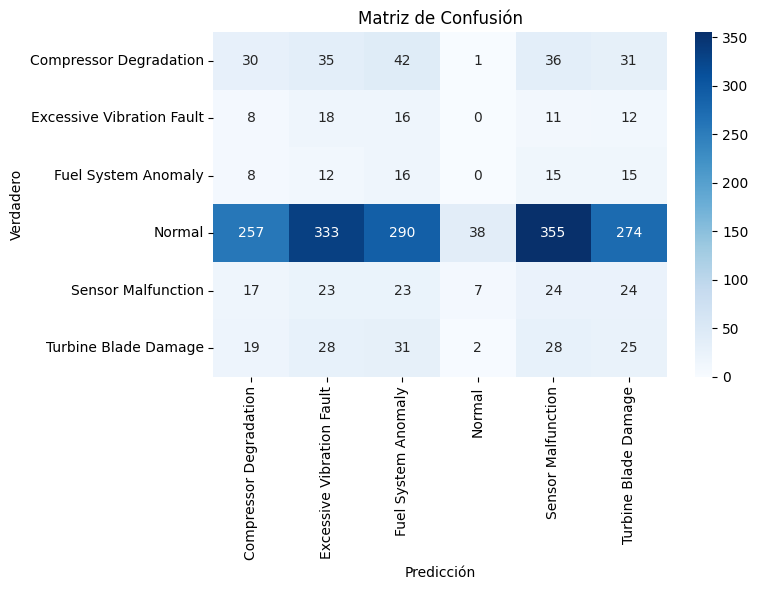

In [33]:
from utils import entrenar_evaluar_pytorch

resultados = entrenar_evaluar_pytorch(
    model=model,
    X_train=X_train.values, 
    X_test=X_test.values,
    y_train=y_train.values,
    y_test=y_test.values,
    le=le,
    epochs=50,
    batch_size=128,
    lr=0.001,
    device=device,         
    class_weights=class_weights
)
mostrar_resultados_notebook(resultados, le)

El modelo MLP mejorado se ha beneficiado del uso de class weights y regularización (Dropout), lo que le permite prestar más atención a las clases minoritarias durante el entrenamiento. Aunque la precisión global (accuracy) ha disminuido respecto a los modelos básicos, los F1-scores por clase minoritaria han mejorado, lo que es más relevante para la detección de fallos, que constituye el objetivo principal del modelo.

Aún existe margen de mejora. Para optimizar el rendimiento, probaremos estrategias como:
- **Incrementar la complejidad del modelo** mediante arquitecturas más profundas o con más neuronas por capa.
- Aplicar técnicas de oversampling, como **SMOTE**, para reforzar la presencia de las clases minoritarias durante el entrenamiento.

## Opimización de Modelos: LSTM

Como se ha observado en los experimentos con modelos MLP, una de las estrategias para mejorar la detección de fallos en helicópteros es incrementar la complejidad del modelo, ya sea mediante arquitecturas más profundas o con más neuronas por capa. Sin embargo, dado que los datos de sensores presentan un comportamiento temporal, algunas anomalías y patrones de fallo solo pueden detectarse considerando la evolución de las señales a lo largo del tiempo.

Por esta razón, una de las alternativas a explorar es el uso de **LSTM** (Long Short-Term Memory). Los LSTM están diseñados para **capturar dependencias temporales y recordar información relevante de secuencias pasadas**, lo que los hace particularmente adecuados para la detección temprana de errores que se desarrollan de manera temporal. Esta capacidad de modelar la dinámica temporal de los sensores podría mejorar la identificación de fallos, especialmente en las clases minoritarias, complementando las mejoras obtenidas con el MLP.

### Preparación de datos

En este caso es necesario cambiar la forma en la que el modelo va a recoger los datos. Para ello definiremos una **ventana** que permita pasarle al modelo los **patrones temporales**. Esto es útil porque:

- **Captura dependencias temporales**: Los fallos pueden no ocurrir instantáneamente. Por ejemplo, un fallo en un rottor puede empezar con vibraciones leves y luego ir aumentando. En ese caso la red necesitará tener en cuena varios pasos consecutivos de los sensores para poder reconocer la secuencia de eventos que lleva al fallo.

- **Evita pérdida de información**: Si no utilizamos una ventana y solo se le da un paso, el LSTM no podría recordar nada del pasado y sería lo mismo que un MLP.

Vamos a comenzar con una ventana fija. En este caso, hemos decidido utilizar una ventana de 50 pasos como punto de partida, ya que permite capturar suficiente información temporal para detectar patrones de fallo sin que la secuencia sea demasiado corta ni demasiado larga. Esto facilita que el LSTM aprenda la transición de estados normales a fallos, manteniendo un balance entre capacidad de detección y eficiencia computacional.

In [48]:
from utils import crear_secuencias_variables, entrenar_evaluar_lstm, preprocesar_datos, mostrar_resultados_notebook_variable
from modelos.lstm import LSTM_basico
from modelos.lstm_ventana_variable import LSTM_vv
from modelos.ventana_lstm import SequenceDataset, collate_fn

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Usando dispositivo: {device}")

Usando dispositivo: cpu


In [35]:
if 'Timestamp' in df.columns:
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])

#cogemos todas las numéricas menos los targets
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cols_to_exclude = ['Fault_Label', 'Fault_Label_Encoded', 'Timestamp', 'target']
features = [c for c in numeric_cols if c not in cols_to_exclude]

le = LabelEncoder()
df_model = df.copy()
df_model['target'] = le.fit_transform(df_model['Fault_Label'])

### LSTM simple

In [36]:
ventana = 50
epochs = 20
batch_size = 32

#Preparar datos
X_raw = df_model[features].values
y_raw = df_model['target'].values

split = int(len(X_raw) * 0.8)
X_train_raw, X_test_raw = X_raw[:split], X_raw[split:]
y_train_raw, y_test_raw = y_raw[:split], y_raw[split:]

In [37]:
#modelo
input_dim = len(features)
output_dim = len(le.classes_)
model_fijo = LSTM_basico(input_dim, hidden_dim=64, num_layers=2, output_dim=output_dim, dropout=0.2)

In [38]:
resultados_lstm = entrenar_evaluar_lstm(
    model=model_fijo,
    X_train=X_train_raw, X_test=X_test_raw,
    y_train=y_train_raw, y_test=y_test_raw,
    le=le,
    epochs=epochs,
    batch_size=batch_size,
    lr=0.001,
    device=device,
    ventana_variable=False,
    ventana=ventana
)

Resultados del Modelo
---------------------
Accuracy: 0.722
Balanced Accuracy: 0.167
F1 Global: 0.606
Kappa: 0.000
Muestras en test: 1353

Métricas por Clase:


,Clase,Precision,Recall,F1
0,Compressor Degradation,0.000,0.000,0.000
1,Excessive Vibration Fault,0.000,0.000,0.000
2,Fuel System Anomaly,0.000,0.000,0.000
3,Normal,0.722,1.000,0.839
4,Sensor Malfunction,0.000,0.000,0.000
5,Turbine Blade Damage,0.000,0.000,0.000


Distribución de clases en el conjunto de test:
  Compressor Degradation: 131 muestras (9.68%)
  Excessive Vibration Fault: 43 muestras (3.18%)
  Fuel System Anomaly: 43 muestras (3.18%)
  Normal: 977 muestras (72.21%)
  Sensor Malfunction: 74 muestras (5.47%)
  Turbine Blade Damage: 85 muestras (6.28%)

Matriz de Confusión:


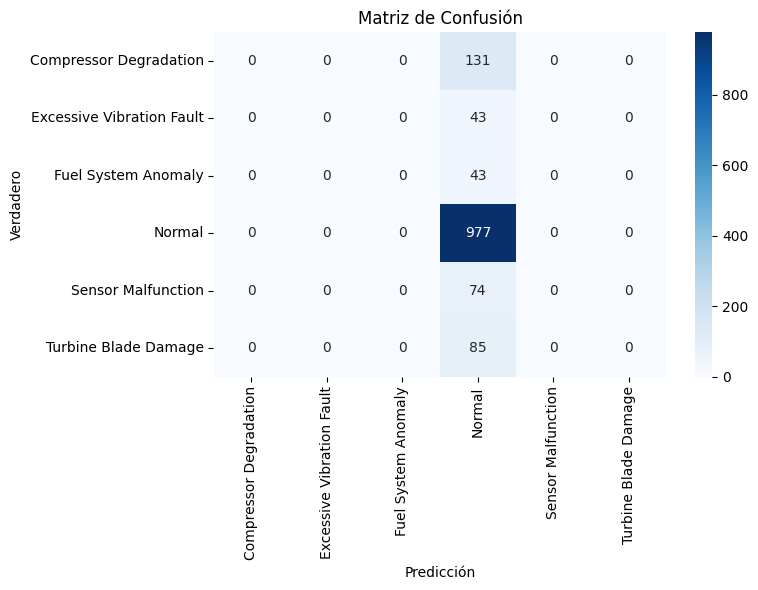

In [39]:
mostrar_resultados_notebook(resultados_lstm, le)

En cuanto a las clases podemos ver que la clase “Normal” sigue siendo la única que se detecta de manera consistente, con un F1 alto y recall elevado, reflejando que el modelo aprende principalmente a predecir la clase mayoritaria.

Por el contrario, las **clases minoritarias** como Compressor Degradation, Excessive Vibration Fault, Fuel System Anomaly, Sensor Malfunction y Turbine Blade Damage muestran F1 muy bajos y recall cercano a cero en la mayoría de los experimentos. Esto indica que la mayoría de sus ejemplos se **clasifican incorrectamente**, usualmente como “Normal” u otras clases minoritarias.

Por tanto, aunque el modelo tenga un accuracy relativamente alto por la predicción correcta de la clase mayoritaria, **no cumple su objetivo principal, que es detectar los fallos raros**. Es por ello que vamos a probar con aplicar class weights para penalizar más los errores en clases minoritarias.

### LSTM con class weights

In [40]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_raw), y=y_train_raw)


resultados_lsmt_cw = entrenar_evaluar_lstm(
    model=model_fijo,
    X_train=X_train_raw, X_test=X_test_raw,
    y_train=y_train_raw, y_test=y_test_raw,
    le=le,
    epochs=epochs,
    batch_size=batch_size,
    lr=0.001,
    device=device,
    class_weights=class_weights,
    ventana_variable=False,
    ventana=ventana
)

Resultados del Modelo
---------------------
Accuracy: 0.354
Balanced Accuracy: 0.183
F1 Global: 0.421
Kappa: 0.013
Muestras en test: 1353

Métricas por Clase:


,Clase,Precision,Recall,F1
0,Compressor Degradation,0.115,0.176,0.139
1,Excessive Vibration Fault,0.080,0.140,0.102
2,Fuel System Anomaly,0.027,0.047,0.034
3,Normal,0.732,0.434,0.545
4,Sensor Malfunction,0.058,0.162,0.085
5,Turbine Blade Damage,0.055,0.141,0.079


Distribución de clases en el conjunto de test:
  Compressor Degradation: 131 muestras (9.68%)
  Excessive Vibration Fault: 43 muestras (3.18%)
  Fuel System Anomaly: 43 muestras (3.18%)
  Normal: 977 muestras (72.21%)
  Sensor Malfunction: 74 muestras (5.47%)
  Turbine Blade Damage: 85 muestras (6.28%)

Matriz de Confusión:


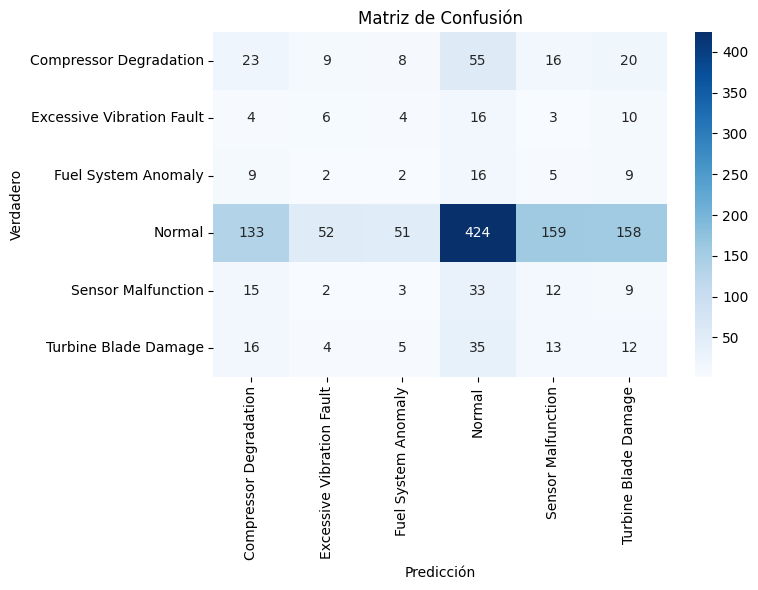

In [41]:
mostrar_resultados_notebook(resultados_lsmt_cw, le)

Como podemos ver, hay una **pequeña mejora en la detección de algunas clases minoritarias**, aunque todavía limitada. Por ejemplo, el recall y F1 de Compressor Degradation, Sensor Malfunction y Turbine Blade Damage muestran valores superiores a los obtenidos sin class weights, lo que indica que el modelo ahora presta más atención a estas clases durante el entrenamiento.

No obstante, las clases extremadamente minoritarias como Excessive Vibration Fault y Fuel System Anomaly siguen teniendo F1 y recall muy bajos, reflejando que el aprendizaje sigue siendo **insuficiente para fallos muy raros**.

En cuanto a la clase “Normal”, el F1 y el recall disminuyen respecto al modelo sin class weights, lo que es esperable ya que el modelo ahora reparte su atención entre varias clases, sacrificando parte del rendimiento en la clase mayoritaria para mejorar la detección de las minoritarias.

Por tanto, el uso de class weights ayuda a mejorar la sensibilidad hacia los fallos minoritarios, pero aún es necesario combinar esta estrategia con oversampling o ajustes de arquitectura para lograr una detección robusta de todas las clases de fallo.

### LSTM con ventana variable

In [42]:
X_seqs, y_seqs = crear_secuencias_variables(df_model, features, 'target')
X_seqs = [seq.astype(np.float32) for seq in X_seqs]

print(f"Secuencias generadas: {len(X_seqs)}")

Secuencias generadas: 6428


In [43]:
split_idx = int(len(X_seqs) * 0.8)
X_train_seq = X_seqs[:split_idx]
X_test_seq = X_seqs[split_idx:]
y_train_seq = y_seqs[:split_idx]
y_test_seq = y_seqs[split_idx:]

train_ds = SequenceDataset(X_train_seq, y_train_seq)
test_ds = SequenceDataset(X_test_seq, y_test_seq)

In [44]:
model_variable = LSTM_vv(input_dim, hidden_dim=64, num_layers=2, output_dim=output_dim, dropout=0.2)

#pesos (asegurando todas las clases)
classes_present = np.unique(y_train_seq)
weights_calc = compute_class_weight('balanced', classes=classes_present, y=y_train_seq)
weights_full = np.ones(output_dim)
weights_full[classes_present] = weights_calc

In [45]:
resultados_variable = entrenar_evaluar_lstm(
    model=model_variable,
    X_train=None, X_test=None, y_train=None, y_test=None,
    le=le,
    train_dataset=train_ds,
    test_dataset=test_ds,
    epochs=20,
    batch_size=32,
    lr=0.001,
    device=device,
    class_weights=weights_full,
    ventana_variable=True,
    collate_fn=collate_fn
)

Resultados del Modelo (Variable)
--------------------------------
Accuracy: 0.321
Balanced Accuracy: 0.199
F1 Global: 0.413
Kappa: -0.005
Muestras en test: 1286

Métricas por Clase:


,Clase,Precision,Recall,F1
0,Compressor Degradation,0.000,0.000,0.000
1,Excessive Vibration Fault,0.028,0.114,0.045
2,Fuel System Anomaly,0.051,0.182,0.080
3,Normal,0.794,0.361,0.496
4,Sensor Malfunction,0.055,0.152,0.081
5,Turbine Blade Damage,0.064,0.187,0.095


Distribución de clases en el conjunto de test:
  Compressor Degradation: 0 muestras (0.00%)
  Excessive Vibration Fault: 44 muestras (3.42%)
  Fuel System Anomaly: 44 muestras (3.42%)
  Normal: 1028 muestras (79.94%)
  Sensor Malfunction: 79 muestras (6.14%)
  Turbine Blade Damage: 91 muestras (7.08%)

Matriz de Confusión:


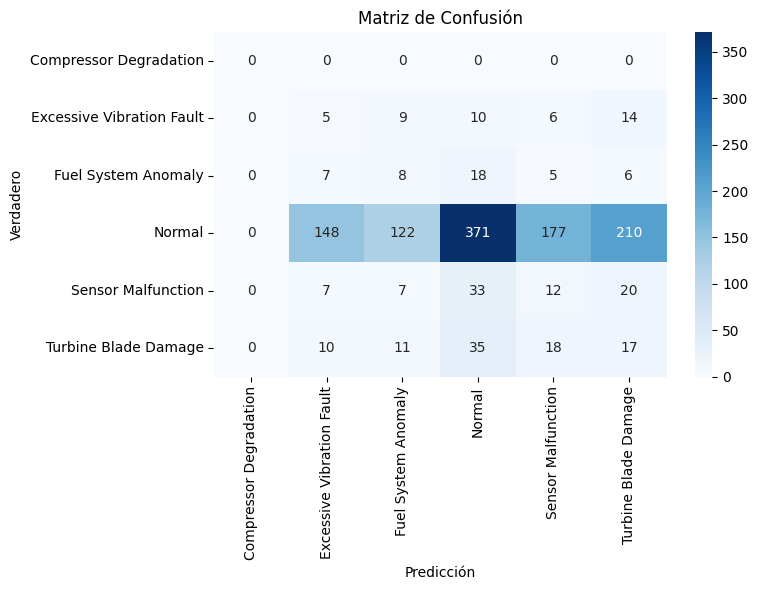

In [49]:
mostrar_resultados_notebook_variable(resultados_variable, le)